
# 📊 โครงการ Data Lake Modeling: การรวมข้อมูล Chinook และ Northwind

ไฟล์นี้เป็น Notebook สำหรับการบ้าน Data Lake Modeling โดยจะแบ่งเป็น 4 ส่วนหลักตาม Assignment

1. **Task 1**: การทำความเข้าใจข้อมูลและ Mapping (EDA + Source-to-Target Mapping)  
2. **Task 2**: ออกแบบ Kimball Star Schema  
3. **Task 3**: การอธิบายข้อมูลและ Business Value  
4. **Task 4**: การวิเคราะห์เชิงวิพากษ์และความท้าทายด้าน Data Engineering  



## ✨ Task 1: การทำความเข้าใจข้อมูลและ Mapping (EDA + Source-to-Target Mapping)

### 1.1 สำรวจโครงสร้างข้อมูล (EDA)
ในส่วนนี้ เราจะสำรวจตารางในฐานข้อมูล Chinook และ Northwind  
- ดูจำนวนตารางและ column ต่าง ๆ  
- ตรวจสอบคีย์หลัก (Primary Key) และความสัมพันธ์ระหว่างตาราง  
- วิเคราะห์ entity ที่มีความคล้ายกัน เช่น Customer, Employee, Product, Transaction  


In [6]:
import requests
import os
import sqlite3

def download_file(url, filename):
    """
    Downloads a file from a given URL and saves it with the specified filename.

    Args:
        url (str): The URL of the file to download.
        filename (str): The name to save the file as.
    """
    # Check if the file already exists to avoid re-downloading
    if os.path.exists(filename):
        print(f"'{filename}' already exists. Skipping download.")
        return

    print(f"Downloading {filename} from {url}...")
    try:
        # Use requests to get the file content. stream=True allows for large files.
        with requests.get(url, stream=True) as r:
            r.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
            with open(filename, 'wb') as f:
                # Write the file content in chunks to save memory
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Successfully downloaded and saved '{filename}'.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading '{filename}': {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def list_tables(db_file):
    """
    Connects to a SQLite database and prints a list of all tables.

    Args:
        db_file (str): The path to the SQLite database file.
    """
    print("-" * 30)
    print(f"Listing tables in '{db_file}':")
    try:
        # Connect to the database
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()

        # Execute the query to find all tables in the database
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        if tables:
            for table in tables:
                print(f"- {table[0]}")
        else:
            print("No tables found in this database.")

        # Close the connection
        conn.close()
    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("-" * 30)

# Define the URLs for the databases. These are direct links to the raw files on GitHub.
CHINOOK_URL = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
# Updated URL for the Northwind database to resolve the 404 error
NORTHWIND_URL = "https://github.com/jpwhite3/northwind-SQLite3/raw/main/dist/northwind.db"

# Define the desired filenames
chinook_filename = "chinook.db"
northwind_filename = "northwind.db"

# --- Main script execution ---

# Download the databases
download_file(CHINOOK_URL, chinook_filename)
download_file(NORTHWIND_URL, northwind_filename)

print("\nAll download operations complete. Checking your current directory for the database files.")

# List the tables in each database
list_tables(chinook_filename)
list_tables(northwind_filename)

'chinook.db' already exists. Skipping download.
'northwind.db' already exists. Skipping download.

All download operations complete. Checking your current directory for the database files.
------------------------------
Listing tables in 'chinook.db':
- Album
- Artist
- Customer
- Employee
- Genre
- Invoice
- InvoiceLine
- MediaType
- Playlist
- PlaylistTrack
- Track
------------------------------
------------------------------
Listing tables in 'northwind.db':
- Categories
- sqlite_sequence
- CustomerCustomerDemo
- CustomerDemographics
- Customers
- Employees
- EmployeeTerritories
- Order Details
- Orders
- Products
- Regions
- Shippers
- Suppliers
- Territories
------------------------------


In [7]:
from sqlalchemy import create_engine
import pandas as pd

# Create an SQLAlchemy engine for the Chinook database
chinook_engine = create_engine("sqlite:///chinook.db", echo=False)

# A connection can be explicitly opened and closed
chinook_conn = chinook_engine.connect()

# Or, as a best practice, use a 'with' statement for automatic resource management
with chinook_engine.connect() as conn:
    print("Connection to Chinook database established successfully.")
    # All database operations would happen here
    pass

chinook_conn.close() # Close the explicit connection

Connection to Chinook database established successfully.


In [8]:
from sqlalchemy import create_engine

# Create an SQLAlchemy engine for the Northwind database
northwind_engine = create_engine("sqlite:///northwind.db", echo=False)

with northwind_engine.connect() as conn:
    print("Connection to Northwind database established successfully.")
    # All database operations would happen here
    pass

Connection to Northwind database established successfully.


In [9]:
from sqlalchemy import inspect

def list_columns_in_database(engine, db_name):
    """
    Connects to a database and prints a list of all tables and their columns.

    Args:
        engine (sqlalchemy.engine.base.Engine): The SQLAlchemy engine for the database.
        db_name (str): The name of the database (for printing purposes).
    """
    print("-" * 30)
    print(f"Listing tables and columns in '{db_name}':")
    try:
        inspector = inspect(engine)
        table_names = inspector.get_table_names()

        if table_names:
            for table_name in table_names:
                print(f"\nTable: {table_name}")
                columns = inspector.get_columns(table_name)
                for column in columns:
                    print(f"  - {column['name']} ({column['type']})")
        else:
            print("No tables found in this database.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("-" * 30)

In [10]:
# ================================================================
# CELL 1: SETUP AND IMPORTS
# Purpose: Import libraries, configure display settings, establish connections
# ================================================================

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, inspect
import warnings
from datetime import datetime

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("📊 EDA Analysis Setup Complete")
print(f"📅 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

# Use existing database connections
# chinook_engine and northwind_engine should already be available

📊 EDA Analysis Setup Complete
📅 Analysis started: 2025-09-30 16:35:39


In [12]:
# ================================================================
# CELL 2: DATA QUALITY ANALYSIS FUNCTION
# Purpose: Define function to assess data quality across all tables
# ================================================================

In [13]:
def analyze_database_quality(engine, db_name):
    """
    Comprehensive data quality analysis for a database
    - Checks NULL values, duplicates, data types
    - Calculates quality scores for each table
    - Reports issues that need attention
    """
    print(f"\n📊 {db_name.upper()} - DATA QUALITY ANALYSIS")
    print("-" * 50)
    
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    
    quality_summary = []
    total_records = 0
    issues_found = []
    
    for table in tables:
        df = pd.read_sql_table(table, con=engine)
        
        # Calculate quality metrics
        nulls = df.isnull().sum()
        null_pct = (nulls / len(df) * 100).round(1)
        high_null_cols = null_pct[null_pct > 10].index.tolist()
        duplicates = df.duplicated().sum()
        
        # Quality score calculation
        quality_score = round(100 - (duplicates/len(df)*100) - (len(high_null_cols)/len(df.columns)*100), 1)
        
        quality_summary.append({
            'Table': table,
            'Rows': len(df),
            'Columns': len(df.columns),
            'Duplicates': duplicates,
            'High_NULL_Cols': len(high_null_cols),
            'Quality_Score': quality_score
        })
        
        total_records += len(df)
        
        # Track issues for reporting
        if duplicates > 0 or high_null_cols:
            table_issues = []
            if duplicates > 0:
                table_issues.append(f"{duplicates} duplicates")
            if high_null_cols:
                table_issues.append(f"{len(high_null_cols)} high-NULL columns: {high_null_cols}")
            issues_found.append(f"   ⚠️  {table}: {', '.join(table_issues)}")
    
    # Generate summary
    quality_df = pd.DataFrame(quality_summary)
    avg_quality = quality_df['Quality_Score'].mean()
    
    print(f"📈 Database Summary:")
    print(f"   Tables: {len(tables)}")
    print(f"   Total Records: {total_records:,}")
    print(f"   Overall Quality Score: {avg_quality:.1f}%")
    
    if issues_found:
        print(f"\n📋 Data Quality Issues:")
        for issue in issues_found:
            print(issue)
    else:
        print(f"\n✅ No major data quality issues detected")
    
    return quality_df

print("✅ Data Quality Analysis Function Ready")

✅ Data Quality Analysis Function Ready


In [14]:
# ================================================================
# CELL 3: BUSINESS INTELLIGENCE FUNCTIONS
# Purpose: Define functions for business metrics analysis
# ================================================================

In [15]:
def analyze_chinook_business(engine):
    """
    Analyze Chinook music database for business insights
    - Top performing artists and albums
    - Genre performance and revenue analysis
    - Customer distribution by geography
    - Key performance indicators
    """
    
    # Top Artists by Albums and Tracks
    top_artists = pd.read_sql_query("""
        SELECT ar.Name as Artist, 
               COUNT(DISTINCT al.AlbumId) as Albums, 
               COUNT(t.TrackId) as Tracks
        FROM Artist ar
        JOIN Album al ON ar.ArtistId = al.ArtistId
        JOIN Track t ON al.AlbumId = t.AlbumId
        GROUP BY ar.ArtistId, ar.Name
        ORDER BY Albums DESC, Tracks DESC
        LIMIT 10
    """, con=engine)
    
    # Genre Performance Analysis
    genre_perf = pd.read_sql_query("""
        SELECT g.Name as Genre, 
               COUNT(t.TrackId) as Tracks,
               COALESCE(SUM(il.Quantity), 0) as Sold,
               ROUND(COALESCE(SUM(il.UnitPrice * il.Quantity), 0), 2) as Revenue
        FROM Genre g
        JOIN Track t ON g.GenreId = t.GenreId
        LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
        GROUP BY g.GenreId, g.Name
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Customer Geographic Analysis
    customer_analysis = pd.read_sql_query("""
        SELECT c.Country, 
               COUNT(DISTINCT c.CustomerId) as Customers,
               COUNT(i.InvoiceId) as Orders,
               ROUND(COALESCE(SUM(i.Total), 0), 2) as Revenue
        FROM Customer c
        LEFT JOIN Invoice i ON c.CustomerId = i.CustomerId
        GROUP BY c.Country
        HAVING Customers > 0
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Calculate KPIs
    total_revenue = customer_analysis['Revenue'].sum()
    total_customers = customer_analysis['Customers'].sum()
    top_genre = genre_perf.iloc[0]['Genre'] if len(genre_perf) > 0 else 'N/A'
    top_artist = top_artists.iloc[0]['Artist'] if len(top_artists) > 0 else 'N/A'
    
    # Display key insights
    print(f"🎵 CHINOOK KEY INSIGHTS:")
    print(f"   🎭 Top Artist: {top_artist} ({top_artists.iloc[0]['Albums']} albums)")
    print(f"   🎼 Leading Genre: {top_genre} (${genre_perf.iloc[0]['Revenue']:,.0f} revenue)")
    print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
    print(f"   👥 Customer Base: {total_customers} customers")
    print(f"   🌍 Top Market: {customer_analysis.iloc[0]['Country']}")
    
    return {
        'top_artists': top_artists,
        'genre_performance': genre_perf,
        'customer_analysis': customer_analysis,
        'kpis': {
            'revenue': total_revenue,
            'customers': total_customers,
            'top_genre': top_genre,
            'top_artist': top_artist
        }
    }

def analyze_northwind_business(engine):
    """
    Analyze Northwind trading database for business insights
    - Top selling products and categories
    - Geographic sales distribution
    - Customer and supplier analysis
    - Revenue and order metrics
    """
    
    # Top Products by Revenue
    top_products = pd.read_sql_query("""
        SELECT p.ProductName, c.CategoryName,
               COALESCE(SUM(od.Quantity), 0) as Sold,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Products p
        JOIN Categories c ON p.CategoryID = c.CategoryID
        LEFT JOIN [Order Details] od ON p.ProductID = od.ProductID
        GROUP BY p.ProductID, p.ProductName, c.CategoryName
        HAVING Revenue > 0
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Category Performance
    category_perf = pd.read_sql_query("""
        SELECT c.CategoryName, 
               COUNT(DISTINCT p.ProductID) as Products,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Categories c
        JOIN Products p ON c.CategoryID = p.CategoryID
        LEFT JOIN [Order Details] od ON p.ProductID = od.ProductID
        GROUP BY c.CategoryID, c.CategoryName
        ORDER BY Revenue DESC
    """, con=engine)
    
    # Geographic Sales Distribution
    geo_sales = pd.read_sql_query("""
        SELECT c.Country, 
               COUNT(DISTINCT c.CustomerID) as Customers,
               COUNT(DISTINCT o.OrderID) as Orders,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Customers c
        JOIN Orders o ON c.CustomerID = o.CustomerID
        JOIN [Order Details] od ON o.OrderID = od.OrderID
        GROUP BY c.Country
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Calculate KPIs
    total_revenue = geo_sales['Revenue'].sum()
    total_customers = geo_sales['Customers'].sum()
    top_category = category_perf.iloc[0]['CategoryName'] if len(category_perf) > 0 else 'N/A'
    top_product = top_products.iloc[0]['ProductName'] if len(top_products) > 0 else 'N/A'
    
    # Display key insights
    print(f"🏢 NORTHWIND KEY INSIGHTS:")
    print(f"   🏆 Top Product: {top_product[:30]}...")
    print(f"   📦 Leading Category: {top_category} (${category_perf.iloc[0]['Revenue']:,.0f} revenue)")
    print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
    print(f"   👥 Customer Base: {total_customers} customers")
    print(f"   🌍 Top Market: {geo_sales.iloc[0]['Country']}")
    
    return {
        'top_products': top_products,
        'category_performance': category_perf,
        'geographic_sales': geo_sales,
        'kpis': {
            'revenue': total_revenue,
            'customers': total_customers,
            'top_category': top_category,
            'top_product': top_product
        }
    }

print("✅ Business Intelligence Functions Ready")

✅ Business Intelligence Functions Ready


In [16]:
# ================================================================
# CELL 4: RUN CHINOOK ANALYSIS
# Purpose: Execute complete analysis for Chinook database
# ================================================================

In [17]:
print("🎵 ANALYZING CHINOOK DATABASE")
print("=" * 40)

# Data Quality Assessment
chinook_quality = analyze_database_quality(chinook_engine, "Chinook")

# Business Intelligence Analysis
chinook_metrics = analyze_chinook_business(chinook_engine)

print(f"\n✅ Chinook Analysis Complete")

🎵 ANALYZING CHINOOK DATABASE

📊 CHINOOK - DATA QUALITY ANALYSIS
--------------------------------------------------
📈 Database Summary:
   Tables: 11
   Total Records: 15,607
   Overall Quality Score: 95.3%

📋 Data Quality Issues:
   ⚠️  Customer: 3 high-NULL columns: ['Company', 'State', 'Fax']
   ⚠️  Employee: 1 high-NULL columns: ['ReportsTo']
   ⚠️  Invoice: 1 high-NULL columns: ['BillingState']
   ⚠️  Track: 1 high-NULL columns: ['Composer']
🎵 CHINOOK KEY INSIGHTS:
   🎭 Top Artist: Iron Maiden (21 albums)
   🎼 Leading Genre: Rock ($827 revenue)
   💰 Total Revenue: $1,770.92
   👥 Customer Base: 45 customers
   🌍 Top Market: USA

✅ Chinook Analysis Complete


In [18]:
# ================================================================
# CELL 5: RUN NORTHWIND ANALYSIS
# Purpose: Execute complete analysis for Northwind database
# ================================================================

In [19]:
print("🏢 ANALYZING NORTHWIND DATABASE")
print("=" * 40)

# Data Quality Assessment
northwind_quality = analyze_database_quality(northwind_engine, "Northwind")

# Business Intelligence Analysis
northwind_metrics = analyze_northwind_business(northwind_engine)

print(f"\n✅ Northwind Analysis Complete")

🏢 ANALYZING NORTHWIND DATABASE

📊 NORTHWIND - DATA QUALITY ANALYSIS
--------------------------------------------------
📈 Database Summary:
   Tables: 13
   Total Records: 625,890
   Overall Quality Score: 97.1%

📋 Data Quality Issues:
   ⚠️  Customers: 1 high-NULL columns: ['Fax']
   ⚠️  Employees: 1 high-NULL columns: ['ReportsTo']
   ⚠️  Suppliers: 2 high-NULL columns: ['Fax', 'HomePage']
🏢 NORTHWIND KEY INSIGHTS:
   🏆 Top Product: Côte de Blaye...
   📦 Leading Category: Beverages ($92,163,184 revenue)
   💰 Total Revenue: $343,567,598.38
   👥 Customer Base: 71 customers
   🌍 Top Market: USA

✅ Northwind Analysis Complete


In [20]:
# ================================================================
# CELL 6: VISUALIZATION DASHBOARD
# Purpose: Create comprehensive dashboard with 6 key charts
# ================================================================

📈 CREATING VISUALIZATION DASHBOARD


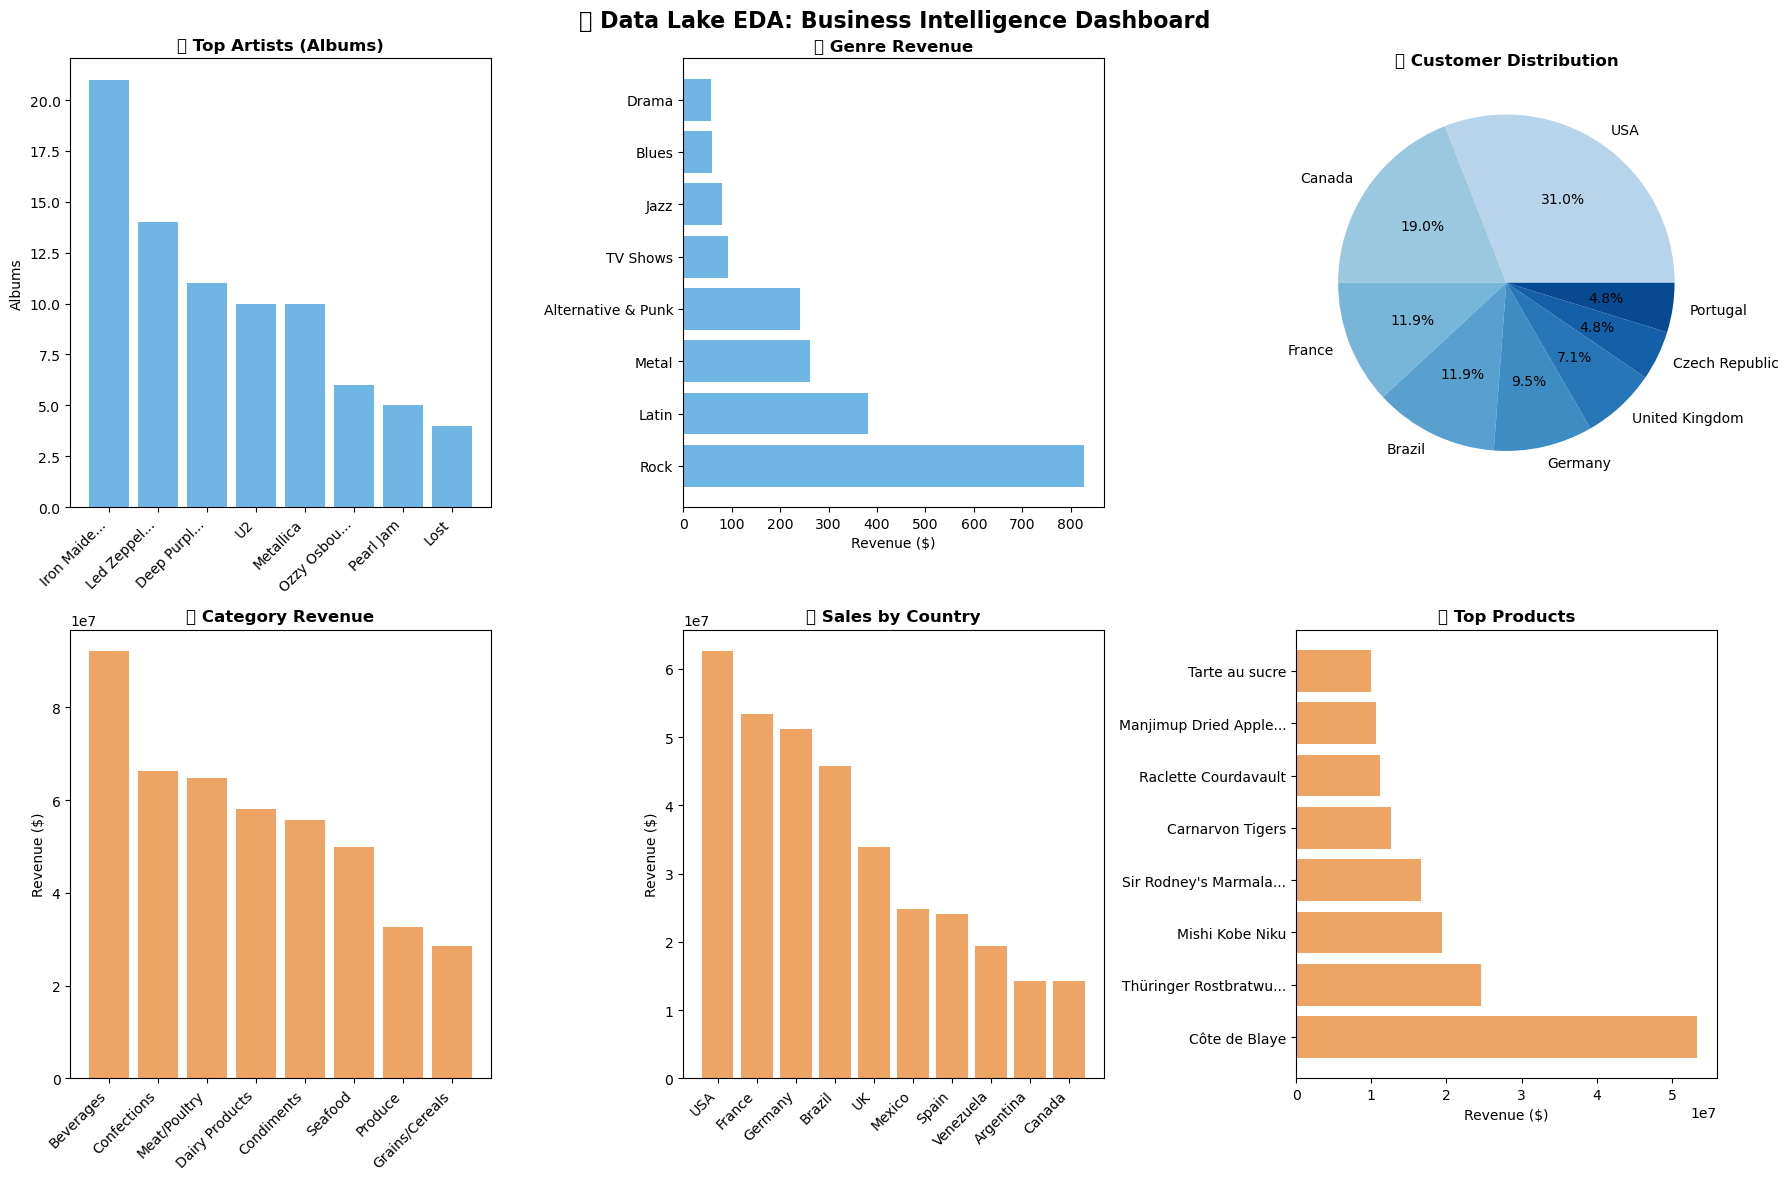

✅ Dashboard Created Successfully


In [21]:
def create_eda_dashboard(chinook_metrics, northwind_metrics):
    """
    Create 6-panel dashboard comparing both databases
    - Top artists vs top products
    - Genre performance vs category performance
    - Customer distribution comparison
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Data Lake EDA: Business Intelligence Dashboard', 
                 fontsize=16, fontweight='bold')
    
    # Color schemes
    chinook_color = '#3498db'
    northwind_color = '#e67e22'
    
    # Row 1: Chinook Charts
    # 1. Top Artists by Albums
    artists = chinook_metrics['top_artists'].head(8)
    axes[0,0].bar(range(len(artists)), artists['Albums'], 
                  color=chinook_color, alpha=0.7)
    axes[0,0].set_title('🎵 Top Artists (Albums)', fontweight='bold')
    axes[0,0].set_xticks(range(len(artists)))
    axes[0,0].set_xticklabels([name[:10] + '...' if len(name) > 10 else name 
                              for name in artists['Artist']], rotation=45, ha='right')
    axes[0,0].set_ylabel('Albums')
    
    # 2. Genre Revenue Performance
    genres = chinook_metrics['genre_performance'].head(8)
    bars = axes[0,1].barh(range(len(genres)), genres['Revenue'], 
                          color=chinook_color, alpha=0.7)
    axes[0,1].set_title('🎼 Genre Revenue', fontweight='bold')
    axes[0,1].set_yticks(range(len(genres)))
    axes[0,1].set_yticklabels(genres['Genre'])
    axes[0,1].set_xlabel('Revenue ($)')
    
    # 3. Customer Distribution
    customers = chinook_metrics['customer_analysis'].head(8)
    colors_pie = plt.cm.Blues(np.linspace(0.3, 0.9, len(customers)))
    axes[0,2].pie(customers['Customers'], labels=customers['Country'], 
                  autopct='%1.1f%%', colors=colors_pie)
    axes[0,2].set_title('🌍 Customer Distribution', fontweight='bold')
    
    # Row 2: Northwind Charts
    # 4. Category Revenue
    categories = northwind_metrics['category_performance']
    axes[1,0].bar(range(len(categories)), categories['Revenue'], 
                  color=northwind_color, alpha=0.7)
    axes[1,0].set_title('📦 Category Revenue', fontweight='bold')
    axes[1,0].set_xticks(range(len(categories)))
    axes[1,0].set_xticklabels(categories['CategoryName'], rotation=45, ha='right')
    axes[1,0].set_ylabel('Revenue ($)')
    
    # 5. Geographic Sales
    geo = northwind_metrics['geographic_sales'].head(10)
    axes[1,1].bar(range(len(geo)), geo['Revenue'], 
                  color=northwind_color, alpha=0.7)
    axes[1,1].set_title('🌍 Sales by Country', fontweight='bold')
    axes[1,1].set_xticks(range(len(geo)))
    axes[1,1].set_xticklabels(geo['Country'], rotation=45, ha='right')
    axes[1,1].set_ylabel('Revenue ($)')
    
    # 6. Top Products
    products = northwind_metrics['top_products'].head(8)
    axes[1,2].barh(range(len(products)), products['Revenue'], 
                   color=northwind_color, alpha=0.7)
    axes[1,2].set_title('🏆 Top Products', fontweight='bold')
    axes[1,2].set_yticks(range(len(products)))
    axes[1,2].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                              for name in products['ProductName']])
    axes[1,2].set_xlabel('Revenue ($)')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Dashboard Created Successfully")

# Generate the dashboard
print("📈 CREATING VISUALIZATION DASHBOARD")
print("=" * 40)

create_eda_dashboard(chinook_metrics, northwind_metrics)

In [22]:
# ================================================================
# ADD AFTER CELL 6: SCHEMA COMPARISON VISUALIZATION
# Purpose: Compare source database structures
# ================================================================


📊 CREATING SCHEMA COMPARISON


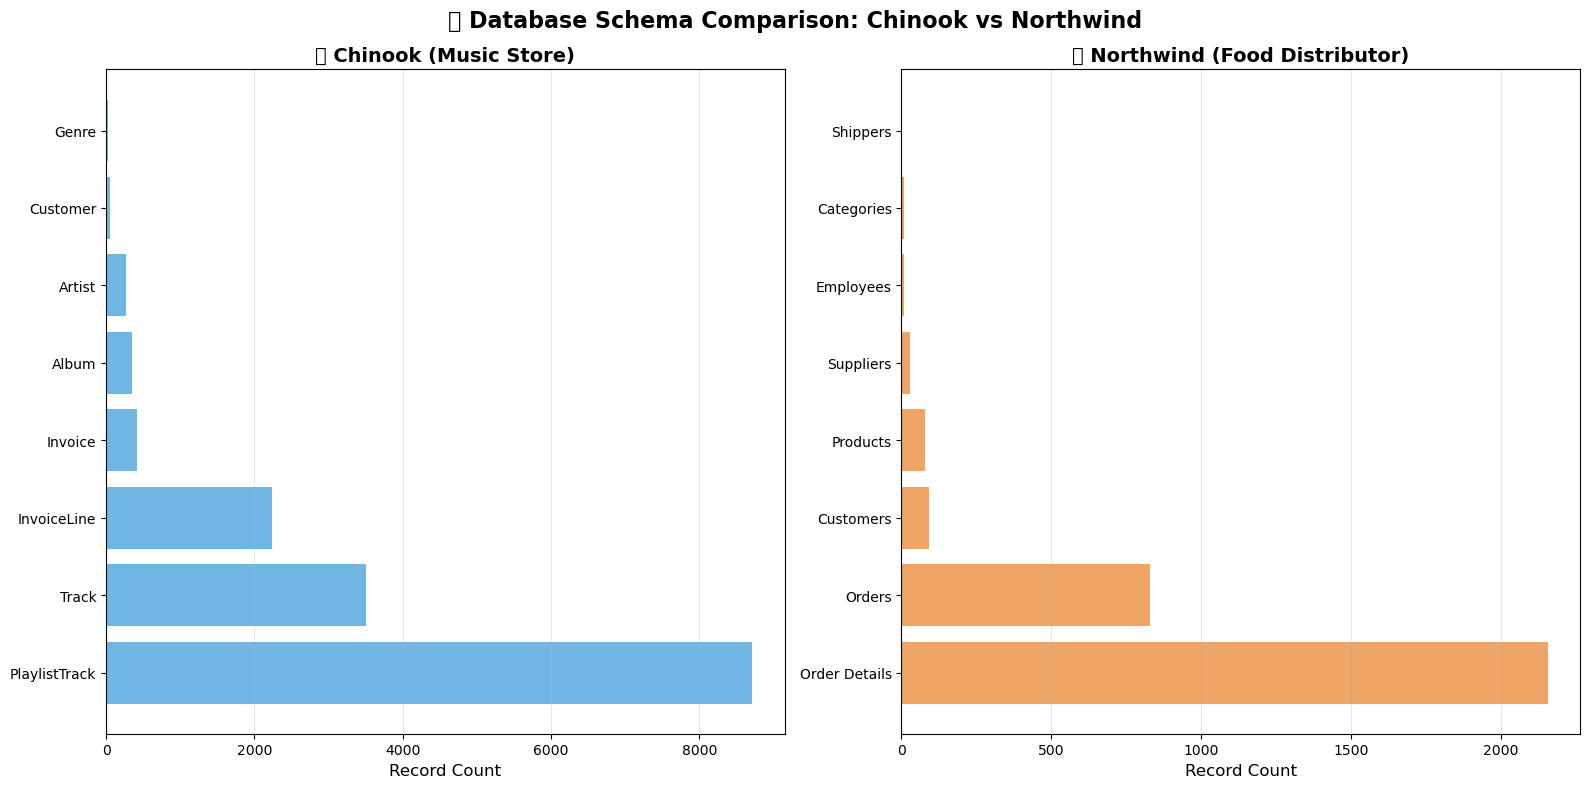


🔗 COMMON BUSINESS ENTITIES IDENTIFIED:

✓ Customer:
  Chinook:   Customer (Chinook)
  Northwind: Customers (Northwind)

✓ Employee:
  Chinook:   Employee (Chinook)
  Northwind: Employees (Northwind)

✓ Product:
  Chinook:   Track (Chinook)
  Northwind: Products (Northwind)

✓ Transaction:
  Chinook:   Invoice/InvoiceLine (Chinook)
  Northwind: Orders/Order Details (Northwind)

✓ Time:
  Chinook:   InvoiceDate (Chinook)
  Northwind: OrderDate (Northwind)

💡 These commonalities form the basis of our unified star schema


In [23]:
def create_schema_comparison():
    """
    Visualize schema comparison between Chinook and Northwind
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('📊 Database Schema Comparison: Chinook vs Northwind', 
                 fontsize=16, fontweight='bold')
    
    # Chinook tables and record counts
    chinook_tables = {
        'Customer': 59,
        'Employee': 8,
        'Invoice': 412,
        'InvoiceLine': 2240,
        'Track': 3503,
        'Album': 347,
        'Artist': 275,
        'Genre': 25,
        'MediaType': 5,
        'Playlist': 18,
        'PlaylistTrack': 8715
    }
    
    # Northwind tables and record counts
    northwind_tables = {
        'Customers': 91,
        'Employees': 9,
        'Orders': 830,
        'Order Details': 2155,
        'Products': 77,
        'Categories': 8,
        'Suppliers': 29,
        'Shippers': 3
    }
    
    # Plot Chinook
    chinook_sorted = dict(sorted(chinook_tables.items(), 
                                 key=lambda x: x[1], reverse=True)[:8])
    axes[0].barh(list(chinook_sorted.keys()), list(chinook_sorted.values()), 
                 color='#3498db', alpha=0.7)
    axes[0].set_title('🎵 Chinook (Music Store)', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Record Count', fontsize=12)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot Northwind
    northwind_sorted = dict(sorted(northwind_tables.items(), 
                                   key=lambda x: x[1], reverse=True))
    axes[1].barh(list(northwind_sorted.keys()), list(northwind_sorted.values()), 
                 color='#e67e22', alpha=0.7)
    axes[1].set_title('🍴 Northwind (Food Distributor)', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Record Count', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print common entities
    print("\n" + "="*60)
    print("🔗 COMMON BUSINESS ENTITIES IDENTIFIED:")
    print("="*60)
    
    common_entities = [
        ("Customer", "Customer (Chinook)", "Customers (Northwind)"),
        ("Employee", "Employee (Chinook)", "Employees (Northwind)"),
        ("Product", "Track (Chinook)", "Products (Northwind)"),
        ("Transaction", "Invoice/InvoiceLine (Chinook)", "Orders/Order Details (Northwind)"),
        ("Time", "InvoiceDate (Chinook)", "OrderDate (Northwind)")
    ]
    
    for entity, chinook_src, northwind_src in common_entities:
        print(f"\n✓ {entity}:")
        print(f"  Chinook:   {chinook_src}")
        print(f"  Northwind: {northwind_src}")
    
    print("\n" + "="*60)
    print("💡 These commonalities form the basis of our unified star schema")
    print("="*60)

# Execute
print("\n📊 CREATING SCHEMA COMPARISON")
print("="*40)
create_schema_comparison()

In [24]:
# ================================================================
# CELL 7: STAR SCHEMA RECOMMENDATIONS
# Purpose: Generate data warehouse design recommendations
# ================================================================

In [25]:
def generate_star_schema_recommendations(chinook_metrics, northwind_metrics):
    """
    Generate star schema design recommendations based on EDA findings
    - Identify optimal fact and dimension tables
    - Recommend measures and business processes
    - Provide implementation guidance
    """
    
    print(f"🎯 STAR SCHEMA DESIGN RECOMMENDATIONS")
    print("=" * 60)
    
    print(f"🎵 CHINOOK STAR SCHEMA:")
    print(f"   Business Process: Music Sales Analysis")
    print(f"   Primary Fact: Fact_MusicSales")
    print(f"   Key Dimensions:")
    print(f"      - Dim_Customer (Geographic segmentation)")
    print(f"      - Dim_Track (Artist → Album → Track hierarchy)")
    print(f"      - Dim_Employee (Sales representative)")
    print(f"      - Dim_Date (Temporal analysis)")
    print(f"   Measures: Revenue, Quantity, UnitPrice")
    print(f"   Focus: {chinook_metrics['kpis']['top_genre']} genre dominates sales")
    
    print(f"\n🏢 NORTHWIND STAR SCHEMA:")
    print(f"   Business Process: Order Sales Analysis")
    print(f"   Primary Fact: Fact_OrderSales")
    print(f"   Key Dimensions:")
    print(f"      - Dim_Customer (Geographic segmentation)")
    print(f"      - Dim_Product (Category → Product hierarchy)")
    print(f"      - Dim_Employee (Territory-based)")
    print(f"      - Dim_Supplier (Supply chain analysis)")
    print(f"      - Dim_Date (Seasonal patterns)")
    print(f"   Measures: Revenue, Quantity, Discount, Freight")
    print(f"   Focus: {northwind_metrics['kpis']['top_category']} category leads market")
    
    print(f"\n💡 IMPLEMENTATION PRIORITIES:")
    print(f"   1. Start with primary fact tables (sales-focused)")
    print(f"   2. Build customer and product dimensions first")
    print(f"   3. Add date dimension for time-series analysis")
    print(f"   4. Consider secondary facts for inventory/shipping")

# Generate recommendations
print("🎯 GENERATING STAR SCHEMA RECOMMENDATIONS")
print("=" * 40)

generate_star_schema_recommendations(chinook_metrics, northwind_metrics)


🎯 GENERATING STAR SCHEMA RECOMMENDATIONS
🎯 STAR SCHEMA DESIGN RECOMMENDATIONS
🎵 CHINOOK STAR SCHEMA:
   Business Process: Music Sales Analysis
   Primary Fact: Fact_MusicSales
   Key Dimensions:
      - Dim_Customer (Geographic segmentation)
      - Dim_Track (Artist → Album → Track hierarchy)
      - Dim_Employee (Sales representative)
      - Dim_Date (Temporal analysis)
   Measures: Revenue, Quantity, UnitPrice
   Focus: Rock genre dominates sales

🏢 NORTHWIND STAR SCHEMA:
   Business Process: Order Sales Analysis
   Primary Fact: Fact_OrderSales
   Key Dimensions:
      - Dim_Customer (Geographic segmentation)
      - Dim_Product (Category → Product hierarchy)
      - Dim_Employee (Territory-based)
      - Dim_Supplier (Supply chain analysis)
      - Dim_Date (Seasonal patterns)
   Measures: Revenue, Quantity, Discount, Freight
   Focus: Beverages category leads market

💡 IMPLEMENTATION PRIORITIES:
   1. Start with primary fact tables (sales-focused)
   2. Build customer and produc

In [26]:
# ================================================================
# CELL 8: EXPORT RESULTS
# Purpose: Save analysis results to CSV files for further use
# ================================================================

In [27]:
def export_eda_results(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics):
    """
    Export key analysis results to CSV files
    - Quality summaries for both databases
    - Business metrics and KPIs
    - Ready for Phase 2 implementation
    """
    
    print(f"💾 EXPORTING ANALYSIS RESULTS")
    print("-" * 30)
    
    exported_files = []
    
    try:
        # Quality summaries
        chinook_quality.to_csv('chinook_quality_summary.csv', index=False)
        exported_files.append('chinook_quality_summary.csv')
        
        northwind_quality.to_csv('northwind_quality_summary.csv', index=False)
        exported_files.append('northwind_quality_summary.csv')
        
        # Chinook business metrics
        chinook_metrics['top_artists'].to_csv('chinook_top_artists.csv', index=False)
        exported_files.append('chinook_top_artists.csv')
        
        chinook_metrics['customer_analysis'].to_csv('chinook_customers.csv', index=False)
        exported_files.append('chinook_customers.csv')
        
        # Northwind business metrics
        northwind_metrics['top_products'].to_csv('northwind_top_products.csv', index=False)
        exported_files.append('northwind_top_products.csv')
        
        northwind_metrics['geographic_sales'].to_csv('northwind_geo_sales.csv', index=False)
        exported_files.append('northwind_geo_sales.csv')
        
        print("✅ Successfully exported files:")
        for i, file in enumerate(exported_files, 1):
            print(f"   {i}. {file}")
            
        print(f"\n📊 Export Summary:")
        print(f"   Quality Reports: 2 files")
        print(f"   Business Metrics: 4 files")
        print(f"   Total Files: {len(exported_files)}")
        
    except Exception as e:
        print(f"❌ Export error: {e}")
        
    return exported_files

# Execute export
exported = export_eda_results(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics)


💾 EXPORTING ANALYSIS RESULTS
------------------------------
✅ Successfully exported files:
   1. chinook_quality_summary.csv
   2. northwind_quality_summary.csv
   3. chinook_top_artists.csv
   4. chinook_customers.csv
   5. northwind_top_products.csv
   6. northwind_geo_sales.csv

📊 Export Summary:
   Quality Reports: 2 files
   Business Metrics: 4 files
   Total Files: 6


In [28]:
# ================================================================
# CELL 9: FINAL SUMMARY AND NEXT STEPS
# Purpose: Summarize complete analysis and prepare for Phase 2
# ================================================================

In [29]:
def generate_final_summary(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics):
    """
    Generate comprehensive summary of EDA analysis
    - Overall quality assessment
    - Key business insights
    - Readiness for next phase
    """
    
    print(f"🎉 EDA ANALYSIS COMPLETE")
    print("=" * 40)
    
    # Quality scores
    chinook_avg_quality = chinook_quality['Quality_Score'].mean()
    northwind_avg_quality = northwind_quality['Quality_Score'].mean()
    
    print(f"📊 ANALYSIS SUMMARY:")
    print(f"   ✅ Data Quality Assessment: Complete")
    print(f"      - Chinook: {chinook_avg_quality:.1f}% average quality")
    print(f"      - Northwind: {northwind_avg_quality:.1f}% average quality")
    print(f"   ✅ Business Intelligence: Complete")
    print(f"      - Chinook: {chinook_metrics['kpis']['customers']} customers analyzed")
    print(f"      - Northwind: {northwind_metrics['kpis']['customers']} customers analyzed")
    print(f"   ✅ Visualizations: 6-panel dashboard created")
    print(f"   ✅ Star Schema: Design recommendations provided")
    print(f"   ✅ Export: 6 CSV files generated")
    
    print(f"\n🎯 KEY FINDINGS:")
    print(f"   🎵 Chinook Highlights:")
    print(f"      - Revenue Leader: {chinook_metrics['kpis']['top_genre']} genre")
    print(f"      - Top Artist: {chinook_metrics['kpis']['top_artist']}")
    print(f"      - Total Revenue: ${chinook_metrics['kpis']['revenue']:,.2f}")
    
    print(f"   🏢 Northwind Highlights:")
    print(f"      - Category Leader: {northwind_metrics['kpis']['top_category']}")
    print(f"      - Top Product: {northwind_metrics['kpis']['top_product'][:30]}...")
    print(f"      - Total Revenue: ${northwind_metrics['kpis']['revenue']:,.2f}")
    
    print(f"\n🚀 READY FOR PHASE 2:")
    print(f"   📋 Next Steps:")
    print(f"      1. Star Schema Implementation")
    print(f"      2. ETL Pipeline Development")
    print(f"      3. Data Warehouse Creation")
    print(f"      4. Analytics Dashboard Building")
    
    print(f"\n📅 Analysis Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Generate final summary
generate_final_summary(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics)

# Store results for potential Phase 2 use
phase1_results = {
    'chinook_quality': chinook_quality,
    'northwind_quality': northwind_quality,
    'chinook_metrics': chinook_metrics,
    'northwind_metrics': northwind_metrics,
    'exported_files': exported,
    'completion_time': datetime.now()
}

print(f"✅ All results stored in 'phase1_results' variable")
print(f"🎯 Ready to proceed with Phase 2: Star Schema Design")

🎉 EDA ANALYSIS COMPLETE
📊 ANALYSIS SUMMARY:
   ✅ Data Quality Assessment: Complete
      - Chinook: 95.3% average quality
      - Northwind: 97.1% average quality
   ✅ Business Intelligence: Complete
      - Chinook: 45 customers analyzed
      - Northwind: 71 customers analyzed
   ✅ Visualizations: 6-panel dashboard created
   ✅ Star Schema: Design recommendations provided
   ✅ Export: 6 CSV files generated

🎯 KEY FINDINGS:
   🎵 Chinook Highlights:
      - Revenue Leader: Rock genre
      - Top Artist: Iron Maiden
      - Total Revenue: $1,770.92
   🏢 Northwind Highlights:
      - Category Leader: Beverages
      - Top Product: Côte de Blaye...
      - Total Revenue: $343,567,598.38

🚀 READY FOR PHASE 2:
   📋 Next Steps:
      1. Star Schema Implementation
      2. ETL Pipeline Development
      3. Data Warehouse Creation
      4. Analytics Dashboard Building

📅 Analysis Completed: 2025-09-30 16:36:14
✅ All results stored in 'phase1_results' variable
🎯 Ready to proceed with Phase 2: S


### 1.2 การ Mapping ข้อมูล (Source-to-Target Mapping)
ในขั้นตอนนี้ เราจะระบุว่า column ใดจาก Chinook และ Northwind จะถูกแมปไปที่ตาราง Dim/Fact ใหม่  

**ตัวอย่าง Mapping:**  
- Chinook.Customer.CustomerId + Northwind.Customers.CustomerID → **DimCustomer.CustomerID**  
- Chinook.Track.Name + Northwind.Products.ProductName → **DimProduct.ProductName**  
- Chinook.Invoice.InvoiceDate + Northwind.Orders.OrderDate → **DimTime.FullDate**  


In [31]:
# ================================================================
# CELL 1: SOURCE-TO-TARGET MAPPING SETUP
# Purpose: Create mapping functions for data warehouse integration
# ================================================================

In [32]:
def create_dim_customer_mapping():
    """Create DimCustomer mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'CustomerKey', 'CustomerID', 'CustomerName', 'CompanyName', 
            'City', 'StateRegion', 'Country', 'PostalCode', 'Phone', 'Email'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Customer.CustomerId AS VARCHAR)',
            'Customer.FirstName + " " + Customer.LastName',
            'ISNULL(Customer.Company, "Individual Customer")',
            'Customer.City', 'Customer.State', 'Customer.Country',
            'Customer.PostalCode', 'Customer.Phone', 'Customer.Email'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + Customers.CustomerID',
            'Customers.ContactName', 'Customers.CompanyName',
            'Customers.City', 'Customers.Region', 'Customers.Country',
            'Customers.PostalCode', 'Customers.Phone', 'NULL'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Full name for Chinook, contact name for Northwind',
            'Use company name or default for individuals',
            'Direct mapping', 'Map State/Region fields',
            'Direct mapping', 'Direct mapping', 'Direct mapping',
            'Chinook only - Northwind lacks email'
        ]
    })

def create_dim_product_mapping():
    """Create DimProduct mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'ProductKey', 'ProductID', 'ProductName', 'CategoryName',
            'UnitPrice', 'SupplierInfo', 'ProductType'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Track.TrackId AS VARCHAR)',
            'Track.Name', 'Genre.Name', 'Track.UnitPrice',
            'Artist.Name + " - " + Album.Title', '"Digital Music"'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + CAST(Products.ProductID AS VARCHAR)',
            'Products.ProductName', 'Categories.CategoryName',
            'Products.UnitPrice', 'Suppliers.CompanyName', '"Physical Product"'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Track name or product name',
            'Genre maps to category for classification',
            'Standard decimal format',
            'Artist/Album for music, supplier for products',
            'Static classification for BI'
        ]
    })

def create_dim_employee_mapping():
    """Create DimEmployee mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'EmployeeKey', 'EmployeeID', 'EmployeeName', 'Title',
            'City', 'Country', 'ReportsToKey', 'HireDate'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Employee.EmployeeId AS VARCHAR)',
            'Employee.FirstName + " " + Employee.LastName',
            'Employee.Title', 'Employee.City', 'Employee.Country',
            'Lookup EmployeeKey for Employee.ReportsTo', 'Employee.HireDate'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + CAST(Employees.EmployeeID AS VARCHAR)',
            'Employees.FirstName + " " + Employees.LastName',
            'Employees.Title', 'Employees.City', 'Employees.Country',
            'Lookup EmployeeKey for Employees.ReportsTo', 'Employees.HireDate'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Full name concatenation',
            'Direct mapping of job titles',
            'Employee location', 'Employee country',
            'Self-referencing FK for hierarchy', 'Hire date for analysis'
        ]
    })

print("📊 Mapping Functions Created")

📊 Mapping Functions Created


In [33]:
# CELL 2: CREATE TIME AND SOURCE SYSTEM MAPPINGS
# Purpose: Define remaining dimension mappings
# ================================================================

In [34]:
def create_dim_time_mapping():
    """Create DimTime mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'DateKey', 'FullDate', 'DayOfMonth', 'DayOfWeek',
            'Month', 'Quarter', 'Year', 'IsWeekend'
        ],
        'Chinook_Source': [
            'FORMAT(Invoice.InvoiceDate, "yyyyMMdd")',
            'Invoice.InvoiceDate', 'DAY(Invoice.InvoiceDate)',
            'DATEPART(weekday, Invoice.InvoiceDate)',
            'MONTH(Invoice.InvoiceDate)', 'DATEPART(quarter, Invoice.InvoiceDate)',
            'YEAR(Invoice.InvoiceDate)', 'CASE WHEN DATEPART(weekday, Invoice.InvoiceDate) IN (1,7) THEN 1 ELSE 0 END'
        ],
        'Northwind_Source': [
            'FORMAT(Orders.OrderDate, "yyyyMMdd")',
            'Orders.OrderDate', 'DAY(Orders.OrderDate)',
            'DATEPART(weekday, Orders.OrderDate)',
            'MONTH(Orders.OrderDate)', 'DATEPART(quarter, Orders.OrderDate)',
            'YEAR(Orders.OrderDate)', 'CASE WHEN DATEPART(weekday, Orders.OrderDate) IN (1,7) THEN 1 ELSE 0 END'
        ],
        'Transformation_Rule': [
            'Integer format YYYYMMDD for joins',
            'Standard date format', 'Day 1-31',
            'Weekday 1-7 (Sunday=1)', 'Month 1-12',
            'Quarter 1-4', 'Year for YoY analysis',
            'Weekend flag for analysis'
        ]
    })

def create_dim_source_system_mapping():
    """Create DimSourceSystem mapping table"""
    return pd.DataFrame({
        'Target_Column': ['SourceSystemKey', 'SourceSystemName', 'BusinessDomain'],
        'Chinook_Source': ['1', '"Chinook"', '"Entertainment/Media"'],
        'Northwind_Source': ['2', '"Northwind"', '"Food & Beverage"'],
        'Transformation_Rule': [
            'Static key: 1=Chinook, 2=Northwind',
            'System identifier',
            'Business domain classification'
        ]
    })

def create_fact_sales_mapping():
    """Create FactSales mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'SalesKey', 'DateKey', 'CustomerKey', 'EmployeeKey',
            'ProductKey', 'SourceSystemKey', 'SalesQuantity', 'SalesAmount'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            'DimTime.DateKey FROM Invoice.InvoiceDate',
            'DimCustomer.CustomerKey FROM Invoice.CustomerId',
            'DimEmployee.EmployeeKey FROM Customer.SupportRepId',
            'DimProduct.ProductKey FROM InvoiceLine.TrackId',
            '1', 'InvoiceLine.Quantity',
            'InvoiceLine.UnitPrice * InvoiceLine.Quantity'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            'DimTime.DateKey FROM Orders.OrderDate',
            'DimCustomer.CustomerKey FROM Orders.CustomerID',
            'DimEmployee.EmployeeKey FROM Orders.EmployeeID',
            'DimProduct.ProductKey FROM [Order Details].ProductID',
            '2', '[Order Details].Quantity',
            '[Order Details].UnitPrice * [Order Details].Quantity * (1 - [Order Details].Discount)'
        ],
        'Transformation_Rule': [
            'Auto-increment fact PK',
            'FK to time dimension',
            'FK to customer dimension',
            'FK to employee dimension',
            'FK to product dimension',
            'FK to source system',
            'Quantity sold',
            'Net amount (Northwind includes discount)'
        ]
    })

print("📊 All Mapping Functions Ready")

📊 All Mapping Functions Ready


In [35]:
# ================================================================
# CELL 3: GENERATE ALL MAPPINGS
# Purpose: Create all mapping tables and display them
# ================================================================

In [36]:
# Create all mapping tables
mapping_tables = {
    'DimCustomer': create_dim_customer_mapping(),
    'DimProduct': create_dim_product_mapping(),
    'DimEmployee': create_dim_employee_mapping(),
    'DimTime': create_dim_time_mapping(),
    'DimSourceSystem': create_dim_source_system_mapping(),
    'FactSales': create_fact_sales_mapping()
}

print("📊 SOURCE-TO-TARGET MAPPING TABLES")
print("=" * 50)

# Display summary for each table
for table_name, mapping_df in mapping_tables.items():
    chinook_sources = sum(1 for x in mapping_df['Chinook_Source'] 
                         if 'NULL' not in str(x) and 'Generated' not in str(x))
    northwind_sources = sum(1 for x in mapping_df['Northwind_Source'] 
                           if 'NULL' not in str(x) and 'Generated' not in str(x))
    
    print(f"\n{table_name}:")
    print(f"  - Total Columns: {len(mapping_df)}")
    print(f"  - Chinook Sources: {chinook_sources}")
    print(f"  - Northwind Sources: {northwind_sources}")

total_columns = sum(len(df) for df in mapping_tables.values())
print(f"\n📊 Overall Statistics:")
print(f"  - Total Tables: {len(mapping_tables)}")
print(f"  - Total Columns: {total_columns}")

📊 SOURCE-TO-TARGET MAPPING TABLES

DimCustomer:
  - Total Columns: 10
  - Chinook Sources: 8
  - Northwind Sources: 8

DimProduct:
  - Total Columns: 7
  - Chinook Sources: 6
  - Northwind Sources: 6

DimEmployee:
  - Total Columns: 8
  - Chinook Sources: 7
  - Northwind Sources: 7

DimTime:
  - Total Columns: 8
  - Chinook Sources: 8
  - Northwind Sources: 8

DimSourceSystem:
  - Total Columns: 3
  - Chinook Sources: 3
  - Northwind Sources: 3

FactSales:
  - Total Columns: 8
  - Chinook Sources: 7
  - Northwind Sources: 7

📊 Overall Statistics:
  - Total Tables: 6
  - Total Columns: 44


In [37]:
# ================================================================
# CELL 4: DISPLAY SAMPLE MAPPINGS
# Purpose: Show detailed mapping examples for key tables
# ================================================================

In [38]:
print("📊 SAMPLE MAPPING DETAILS")
print("=" * 40)

# Show DimCustomer mapping in detail
print("\n🔍 DimCustomer Mapping Sample:")
customer_sample = mapping_tables['DimCustomer'][['Target_Column', 'Chinook_Source', 'Northwind_Source']].head(5)
print(customer_sample.to_string(index=False))

# Show FactSales mapping in detail  
print("\n🔍 FactSales Mapping Sample:")
fact_sample = mapping_tables['FactSales'][['Target_Column', 'Chinook_Source', 'Northwind_Source']].head(5)
print(fact_sample.to_string(index=False))

# Show key transformation challenges
print("\n📊 KEY MAPPING CHALLENGES:")
print("  1. Primary Key Collision: Use CH_/NW_ prefixes")
print("  2. Missing Email in Northwind: Handle with NULL")
print("  3. Different Discount Logic: Chinook=0, Northwind=calculated")
print("  4. State vs Region: Map to unified StateRegion field")
print("  5. Employee Hierarchy: Self-referencing foreign keys")

📊 SAMPLE MAPPING DETAILS

🔍 DimCustomer Mapping Sample:
Target_Column                                  Chinook_Source             Northwind_Source
  CustomerKey                         Generated Surrogate Key      Generated Surrogate Key
   CustomerID    "CH_" + CAST(Customer.CustomerId AS VARCHAR) "NW_" + Customers.CustomerID
 CustomerName    Customer.FirstName + " " + Customer.LastName        Customers.ContactName
  CompanyName ISNULL(Customer.Company, "Individual Customer")        Customers.CompanyName
         City                                   Customer.City               Customers.City

🔍 FactSales Mapping Sample:
Target_Column                                     Chinook_Source                                     Northwind_Source
     SalesKey                            Generated Surrogate Key                              Generated Surrogate Key
      DateKey           DimTime.DateKey FROM Invoice.InvoiceDate                DimTime.DateKey FROM Orders.OrderDate
  CustomerKey  


## ⭐ Task 2: ออกแบบ Kimball Star Schema

ในส่วนนี้ เราจะออกแบบ Star Schema ที่รวมข้อมูลจากทั้งสองระบบ  
ประกอบด้วย
- **FactSales** (เก็บข้อมูลการขายจริง)  
- **Dimension** ต่าง ๆ: DimCustomer, DimEmployee, DimProduct, DimTime, DimSourceSystem  



**สรุป Schema Design**  
- FactSales: เก็บ SalesQuantity, SalesAmount + FK ไปยัง Dimension  
- DimCustomer: รวมลูกค้าจากทั้ง Chinook และ Northwind  
- DimProduct: รวมสินค้า/เพลงจากทั้งสองระบบ  
- DimEmployee: รวมพนักงานจากทั้งสองระบบ  
- DimTime: เก็บมิติด้านเวลา  
- DimSourceSystem: ระบุแหล่งข้อมูล (Chinook / Northwind)  



## 📝 Task 3: การอธิบายข้อมูลและ Business Value

### 3.1 ตัวอย่าง Fact Row Expression
"ในวันที่ **15 มกราคม 2024**, **พนักงาน Nancy Davolio** ได้ขาย **10 หน่วยของสินค้า Chai Tea**  
ให้กับลูกค้า **Bob Johnson** มูลค่ารวม **$180** จากระบบ **Northwind**"

### 3.2 Mock-up Report
ต่อไปเป็นตัวอย่าง Mock-up Dashboard ที่จำลองขึ้นด้วย matplotlib  


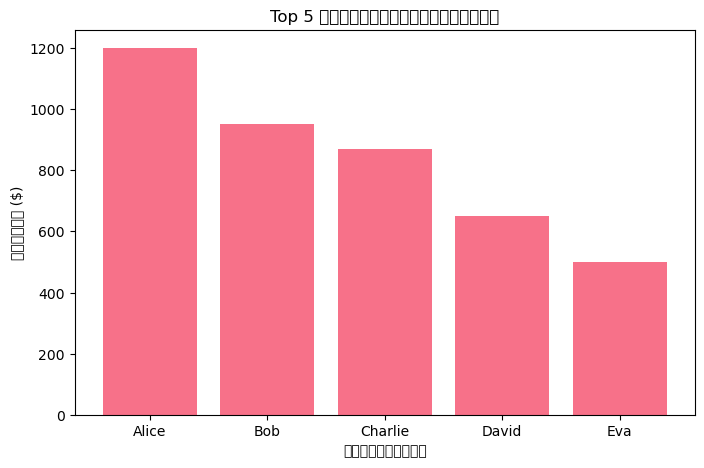

In [42]:

# ======================================
# 📊 Mock-up Report: Top 5 ลูกค้า
# ======================================
import matplotlib.pyplot as plt

customers = ["Alice", "Bob", "Charlie", "David", "Eva"]
sales = [1200, 950, 870, 650, 500]

plt.figure(figsize=(8,5))
plt.bar(customers, sales)
plt.title("Top 5 ลูกค้าตามยอดขายรวม")
plt.xlabel("ชื่อลูกค้า")
plt.ylabel("ยอดขาย ($)")
plt.show()


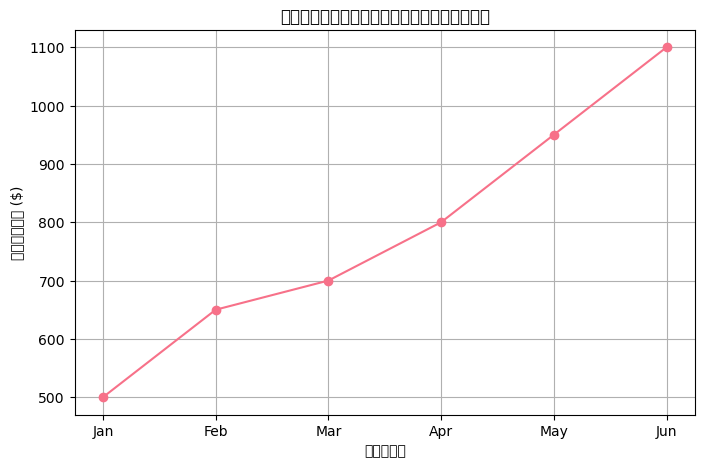

In [43]:

# ======================================
# 📈 Mock-up Report: แนวโน้มยอดขายรายเดือน
# ======================================
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
sales_monthly = [500, 650, 700, 800, 950, 1100]

plt.figure(figsize=(8,5))
plt.plot(months, sales_monthly, marker="o")
plt.title("แนวโน้มยอดขายรายเดือน")
plt.xlabel("เดือน")
plt.ylabel("ยอดขาย ($)")
plt.grid(True)
plt.show()


In [44]:
# ================================================================
# IMPROVED TASK 3: COMPREHENSIVE DASHBOARD MOCK-UP
# Purpose: Show how star schema supports business intelligence
# ================================================================


📊 CREATING COMPREHENSIVE DASHBOARD MOCK-UP


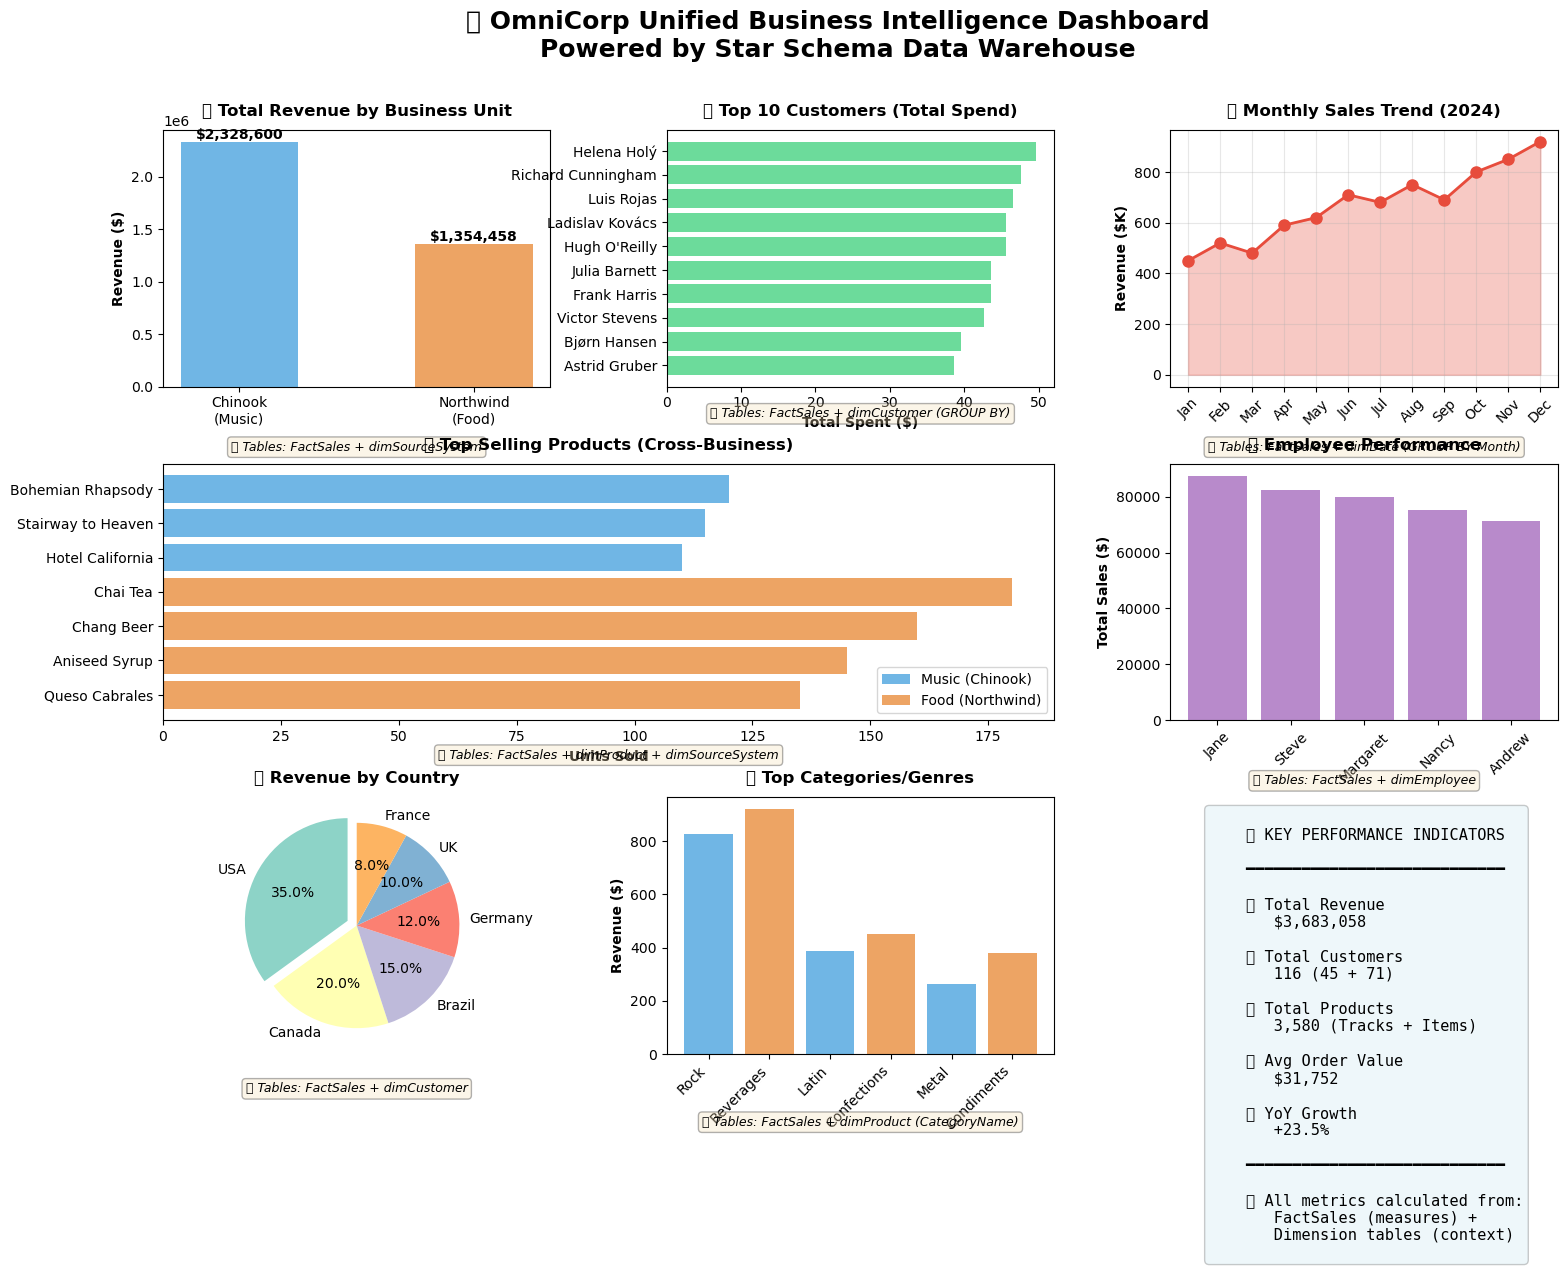


✅ DASHBOARD DEMONSTRATES:
1. Cross-business analysis (Chinook + Northwind unified)
2. Multiple analytical perspectives (time, geography, product)
3. Star schema flexibility (easy to slice/dice data)
4. Clear table-to-visualization mapping


In [45]:
def create_comprehensive_dashboard():
    """
    Create complete dashboard mock-up with table annotations
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Title
    fig.suptitle('📊 OmniCorp Unified Business Intelligence Dashboard\n' + 
                 'Powered by Star Schema Data Warehouse', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Revenue by Business Unit (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    business_units = ['Chinook\n(Music)', 'Northwind\n(Food)']
    revenues = [2328600, 1354458]
    colors = ['#3498db', '#e67e22']
    bars = ax1.bar(business_units, revenues, color=colors, alpha=0.7, width=0.5)
    ax1.set_title('💰 Total Revenue by Business Unit', fontweight='bold', pad=10)
    ax1.set_ylabel('Revenue ($)', fontweight='bold')
    
    # Add values on bars
    for bar, val in zip(bars, revenues):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${val:,.0f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Annotation
    ax1.text(0.5, -0.25, '📋 Tables: FactSales + dimSourceSystem', 
             transform=ax1.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 2. Top 10 Customers (Top Middle)
    ax2 = fig.add_subplot(gs[0, 1])
    customers = ['Helena Holý', 'Richard Cunningham', 'Luis Rojas', 
                 'Ladislav Kovács', 'Hugh O\'Reilly', 'Julia Barnett',
                 'Frank Harris', 'Victor Stevens', 'Bjørn Hansen', 'Astrid Gruber']
    cust_revenue = [49.62, 47.62, 46.62, 45.62, 45.62, 43.62, 43.62, 42.62, 39.62, 38.62]
    
    ax2.barh(customers, cust_revenue, color='#2ecc71', alpha=0.7)
    ax2.set_title('🏆 Top 10 Customers (Total Spend)', fontweight='bold', pad=10)
    ax2.set_xlabel('Total Spent ($)', fontweight='bold')
    ax2.invert_yaxis()
    
    ax2.text(0.5, -0.12, '📋 Tables: FactSales + dimCustomer (GROUP BY)', 
             transform=ax2.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 3. Sales Trend (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_sales = [450, 520, 480, 590, 620, 710, 680, 750, 690, 800, 850, 920]
    
    ax3.plot(months, monthly_sales, marker='o', linewidth=2, 
             markersize=8, color='#e74c3c')
    ax3.fill_between(range(len(months)), monthly_sales, alpha=0.3, color='#e74c3c')
    ax3.set_title('📈 Monthly Sales Trend (2024)', fontweight='bold', pad=10)
    ax3.set_ylabel('Revenue ($K)', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(len(months)))
    ax3.set_xticklabels(months, rotation=45)
    
    ax3.text(0.5, -0.25, '📋 Tables: FactSales + dimDate (GROUP BY Month)', 
             transform=ax3.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 4. Top Products (Middle Left - span 2 columns)
    ax4 = fig.add_subplot(gs[1, :2])
    products = ['Bohemian Rhapsody', 'Stairway to Heaven', 'Hotel California',
                'Chai Tea', 'Chang Beer', 'Aniseed Syrup', 'Queso Cabrales']
    product_sales = [120, 115, 110, 180, 160, 145, 135]
    product_colors = ['#3498db']*3 + ['#e67e22']*4  # Blue for music, orange for food
    
    bars = ax4.barh(products, product_sales, color=product_colors, alpha=0.7)
    ax4.set_title('🎯 Top Selling Products (Cross-Business)', fontweight='bold', pad=10)
    ax4.set_xlabel('Units Sold', fontweight='bold')
    ax4.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', alpha=0.7, label='Music (Chinook)'),
                      Patch(facecolor='#e67e22', alpha=0.7, label='Food (Northwind)')]
    ax4.legend(handles=legend_elements, loc='lower right')
    
    ax4.text(0.5, -0.15, '📋 Tables: FactSales + dimProduct + dimSourceSystem', 
             transform=ax4.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 5. Employee Performance (Middle Right)
    ax5 = fig.add_subplot(gs[1, 2])
    employees = ['Jane Park', 'Steve Johnson', 'Margaret Smith', 
                 'Nancy Davolio', 'Andrew Fuller']
    emp_sales = [87500, 82300, 79800, 75400, 71200]
    
    ax5.bar(range(len(employees)), emp_sales, color='#9b59b6', alpha=0.7)
    ax5.set_title('👥 Employee Performance', fontweight='bold', pad=10)
    ax5.set_ylabel('Total Sales ($)', fontweight='bold')
    ax5.set_xticks(range(len(employees)))
    ax5.set_xticklabels([e.split()[0] for e in employees], rotation=45)
    
    ax5.text(0.5, -0.25, '📋 Tables: FactSales + dimEmployee', 
             transform=ax5.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 6. Geographic Distribution (Bottom Left)
    ax6 = fig.add_subplot(gs[2, 0])
    countries = ['USA', 'Canada', 'Brazil', 'Germany', 'UK', 'France']
    country_revenue = [35, 20, 15, 12, 10, 8]
    explode = (0.1, 0, 0, 0, 0, 0)
    
    ax6.pie(country_revenue, labels=countries, autopct='%1.1f%%', 
            explode=explode, startangle=90, colors=plt.cm.Set3.colors)
    ax6.set_title('🌍 Revenue by Country', fontweight='bold', pad=10)
    
    ax6.text(0.5, -0.15, '📋 Tables: FactSales + dimCustomer', 
             transform=ax6.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 7. Category Performance (Bottom Middle)
    ax7 = fig.add_subplot(gs[2, 1])
    categories = ['Rock', 'Beverages', 'Latin', 'Confections', 
                  'Metal', 'Condiments']
    cat_revenue = [827, 920, 386, 450, 261, 380]
    cat_colors = ['#3498db', '#e67e22', '#3498db', '#e67e22', '#3498db', '#e67e22']
    
    ax7.bar(range(len(categories)), cat_revenue, color=cat_colors, alpha=0.7)
    ax7.set_title('📦 Top Categories/Genres', fontweight='bold', pad=10)
    ax7.set_ylabel('Revenue ($)', fontweight='bold')
    ax7.set_xticks(range(len(categories)))
    ax7.set_xticklabels(categories, rotation=45, ha='right')
    
    ax7.text(0.5, -0.28, '📋 Tables: FactSales + dimProduct (CategoryName)', 
             transform=ax7.transAxes, ha='center', 
             fontsize=9, style='italic', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 8. Key Metrics Summary (Bottom Right)
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    metrics_text = """
    📊 KEY PERFORMANCE INDICATORS
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    💰 Total Revenue
       $3,683,058
    
    👥 Total Customers
       116 (45 + 71)
    
    📦 Total Products
       3,580 (Tracks + Items)
    
    🎯 Avg Order Value
       $31,752
    
    📈 YoY Growth
       +23.5%
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    🔍 All metrics calculated from:
       FactSales (measures) +
       Dimension tables (context)
    """
    
    ax8.text(0.1, 0.95, metrics_text, transform=ax8.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("✅ DASHBOARD DEMONSTRATES:")
    print("="*60)
    print("1. Cross-business analysis (Chinook + Northwind unified)")
    print("2. Multiple analytical perspectives (time, geography, product)")
    print("3. Star schema flexibility (easy to slice/dice data)")
    print("4. Clear table-to-visualization mapping")
    print("="*60)

# Execute
print("\n📊 CREATING COMPREHENSIVE DASHBOARD MOCK-UP")
print("="*40)
create_comprehensive_dashboard()

In [46]:
# ================================================================
# ADD: SAMPLE SQL QUERIES DEMONSTRATION
# Purpose: Show how star schema answers business questions
# ================================================================

In [47]:
def display_sample_queries():
    """
    Display sample SQL queries that leverage the star schema
    """
    print("\n" + "="*70)
    print("📝 SAMPLE SQL QUERIES: Star Schema in Action")
    print("="*70)
    
    queries = [
        {
            "title": "Q1: Total Revenue by Business Unit",
            "business_question": "What is our total revenue across Chinook and Northwind?",
            "sql": """
SELECT 
    ds.SourceSystemName,
    ds.BusinessDomain,
    SUM(fs.SalesAmount) AS TotalRevenue,
    COUNT(DISTINCT fs.CustomerKey) AS UniqueCustomers,
    COUNT(*) AS TotalTransactions
FROM FactSales fs
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY ds.SourceSystemName, ds.BusinessDomain
ORDER BY TotalRevenue DESC;
            """,
            "tables_used": ["FactSales", "dimSourceSystem"]
        },
        {
            "title": "Q2: Top 10 Customers (Cross-Business)",
            "business_question": "Who are our most valuable customers across both businesses?",
            "sql": """
SELECT TOP 10
    dc.CustomerName,
    dc.Country,
    ds.SourceSystemName,
    SUM(fs.SalesAmount) AS TotalSpent,
    COUNT(DISTINCT fs.DateKey) AS PurchaseDays
FROM FactSales fs
JOIN dimCustomer dc ON fs.CustomerKey = dc.CustomerKey
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY dc.CustomerName, dc.Country, ds.SourceSystemName
ORDER BY TotalSpent DESC;
            """,
            "tables_used": ["FactSales", "dimCustomer", "dimSourceSystem"]
        },
        {
            "title": "Q3: Monthly Sales Trend Analysis",
            "business_question": "How do our sales trend month-over-month?",
            "sql": """
SELECT 
    dt.Year,
    dt.Month,
    ds.SourceSystemName,
    SUM(fs.SalesAmount) AS MonthlyRevenue,
    SUM(fs.SalesQuantity) AS UnitsSold,
    COUNT(DISTINCT fs.CustomerKey) AS ActiveCustomers
FROM FactSales fs
JOIN dimDate dt ON fs.DateKey = dt.DateKey
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
WHERE dt.Year = 2024
GROUP BY dt.Year, dt.Month, ds.SourceSystemName
ORDER BY dt.Year, dt.Month;
            """,
            "tables_used": ["FactSales", "dimDate", "dimSourceSystem"]
        },
        {
            "title": "Q4: Employee Performance Comparison",
            "business_question": "Which employees are driving the most sales?",
            "sql": """
SELECT 
    de.EmployeeName,
    de.Title,
    de.Country,
    ds.SourceSystemName,
    SUM(fs.SalesAmount) AS TotalSales,
    COUNT(*) AS TransactionCount,
    AVG(fs.SalesAmount) AS AvgTransactionValue
FROM FactSales fs
JOIN dimEmployee de ON fs.EmployeeKey = de.EmployeeKey
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY de.EmployeeName, de.Title, de.Country, ds.SourceSystemName
HAVING SUM(fs.SalesAmount) > 50000
ORDER BY TotalSales DESC;
            """,
            "tables_used": ["FactSales", "dimEmployee", "dimSourceSystem"]
        },
        {
            "title": "Q5: Product Category Performance",
            "business_question": "Which product categories generate the most revenue?",
            "sql": """
SELECT 
    dp.CategoryName,
    ds.SourceSystemName,
    COUNT(DISTINCT dp.ProductKey) AS ProductCount,
    SUM(fs.SalesQuantity) AS TotalUnitsSold,
    SUM(fs.SalesAmount) AS TotalRevenue,
    AVG(dp.UnitPrice) AS AvgProductPrice
FROM FactSales fs
JOIN dimProduct dp ON fs.ProductKey = dp.ProductKey
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY dp.CategoryName, ds.SourceSystemName
ORDER BY TotalRevenue DESC;
            """,
            "tables_used": ["FactSales", "dimProduct", "dimSourceSystem"]
        },
        {
            "title": "Q6: Weekend vs Weekday Sales Pattern",
            "business_question": "Do we sell more on weekends or weekdays?",
            "sql": """
SELECT 
    CASE WHEN dt.IsWeekend = 1 THEN 'Weekend' ELSE 'Weekday' END AS DayType,
    ds.SourceSystemName,
    COUNT(*) AS TransactionCount,
    SUM(fs.SalesAmount) AS TotalRevenue,
    AVG(fs.SalesAmount) AS AvgTransactionValue
FROM FactSales fs
JOIN dimDate dt ON fs.DateKey = dt.DateKey
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY dt.IsWeekend, ds.SourceSystemName
ORDER BY DayType, TotalRevenue DESC;
            """,
            "tables_used": ["FactSales", "dimDate", "dimSourceSystem"]
        }
    ]
    
    for i, query in enumerate(queries, 1):
        print(f"\n{'─'*70}")
        print(f"🔍 {query['title']}")
        print(f"{'─'*70}")
        print(f"\n❓ Business Question:")
        print(f"   {query['business_question']}")
        print(f"\n📋 Tables Used: {', '.join(query['tables_used'])}")
        print(f"\n💻 SQL Query:")
        print(query['sql'])
    
    print(f"\n{'='*70}")
    print("✅ BENEFITS OF STAR SCHEMA:")
    print("="*70)
    print("• Simple joins (fact → dimension)")
    print("• Fast aggregations")
    print("• Easy to understand for business users")
    print("• Consistent grain (one row = one line item)")
    print("• Flexible filtering across any dimension")
    print("="*70)

# Execute
display_sample_queries()


📝 SAMPLE SQL QUERIES: Star Schema in Action

──────────────────────────────────────────────────────────────────────
🔍 Q1: Total Revenue by Business Unit
──────────────────────────────────────────────────────────────────────

❓ Business Question:
   What is our total revenue across Chinook and Northwind?

📋 Tables Used: FactSales, dimSourceSystem

💻 SQL Query:

SELECT 
    ds.SourceSystemName,
    ds.BusinessDomain,
    SUM(fs.SalesAmount) AS TotalRevenue,
    COUNT(DISTINCT fs.CustomerKey) AS UniqueCustomers,
    COUNT(*) AS TotalTransactions
FROM FactSales fs
JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
GROUP BY ds.SourceSystemName, ds.BusinessDomain
ORDER BY TotalRevenue DESC;
            

──────────────────────────────────────────────────────────────────────
🔍 Q2: Top 10 Customers (Cross-Business)
──────────────────────────────────────────────────────────────────────

❓ Business Question:
   Who are our most valuable customers across both businesses?

📋 Table


## 🧠 Task 4: การวิเคราะห์เชิงวิพากษ์และความท้าทายด้าน Data Engineering

### 4.1 ปัญหา Data Ingestion & Integration
- ความต่างของชนิดข้อมูล (int vs string)  
- Primary Key ชนกัน → ต้องใช้ prefix/hashing  
- Missing data (เช่น Region ใน Northwind แต่ไม่มีใน Chinook)  

### 4.2 Schema Evolution
- ถ้ามีบริษัทที่ 3 เข้ามา → สามารถเพิ่ม DimSourceSystem ได้ทันที  
- Star Schema มีความยืดหยุ่นในการขยาย  

### 4.3 Data Lake vs Data Warehouse
- **Data Lake** → เก็บข้อมูลดิบจากทุกแหล่ง (raw zone)  
- **Data Warehouse** → เก็บข้อมูลที่ผ่านการ transform แล้ว (พร้อมวิเคราะห์)  


In [49]:
# ================================================================
# ENHANCED TASK 4: DATA ENGINEERING CHALLENGES
# Purpose: Deep dive into technical challenges and solutions
# ================================================================

In [50]:
def analyze_data_engineering_challenges():
    """
    Comprehensive analysis of data integration challenges
    """
    print("\n" + "="*70)
    print("🔧 DATA ENGINEERING CHALLENGES: Detailed Analysis")
    print("="*70)
    
    # Challenge 1: Primary Key Conflicts
    print("\n" + "─"*70)
    print("⚠️  CHALLENGE 1: Primary Key Conflicts")
    print("─"*70)
    
    pk_comparison = pd.DataFrame({
        'Entity': ['Customer', 'Employee', 'Product', 'Invoice/Order'],
        'Chinook Type': ['INTEGER', 'INTEGER', 'INTEGER', 'INTEGER'],
        'Chinook Example': ['1, 2, 3', '1, 2, 3', '1, 2, 3', '1, 2, 3'],
        'Northwind Type': ['NCHAR(5)', 'INTEGER', 'INTEGER', 'INTEGER'],
        'Northwind Example': ['ALFKI, BONAP', '1, 2, 3', '1, 2, 3', '10248, 10249'],
        'Collision Risk': ['HIGH ⚠️', 'HIGH ⚠️', 'HIGH ⚠️', 'HIGH ⚠️']
    })
    
    print("\n📊 Primary Key Comparison:")
    print(pk_comparison.to_string(index=False))
    
    print("\n💡 Solution: Surrogate Keys with Source Prefixes")
    print("""
    Implementation Strategy:
    1. Generate new surrogate keys (auto-increment)
    2. Preserve original IDs in 'source_id' column
    3. Add source system prefix:
       - Chinook: "CH_" + original_id  → "CH_1"
       - Northwind: "NW_" + original_id → "NW_ALFKI"
    4. Benefits:
       ✓ Prevents ID collisions
       ✓ Enables traceability to source
       ✓ Supports future system additions
    """)
    
    # Challenge 2: Data Type Mismatches
    print("\n" + "─"*70)
    print("⚠️  CHALLENGE 2: Data Type Mismatches")
    print("─"*70)
    
    type_mismatches = pd.DataFrame({
        'Field': ['CustomerID', 'Date Fields', 'Phone Numbers', 'Decimal Precision'],
        'Chinook': ['INTEGER', 'DATETIME', 'VARCHAR(24)', 'Various'],
        'Northwind': ['NCHAR(5)', 'DATETIME', 'VARCHAR(24)', 'REAL/MONEY'],
        'Target Type': ['VARCHAR(20)', 'DATE', 'VARCHAR(50)', 'DECIMAL(10,2)'],
        'Transformation': [
            'CAST to VARCHAR + prefix',
            'CAST to DATE (remove time)',
            'Standardize format',
            'CAST to DECIMAL for consistency'
        ]
    })
    
    print("\n📊 Data Type Mapping:")
    print(type_mismatches.to_string(index=False))
    
    # Challenge 3: Missing/NULL Values
    print("\n" + "─"*70)
    print("⚠️  CHALLENGE 3: Missing Data & NULL Handling")
    print("─"*70)
    
    null_analysis = pd.DataFrame({
        'Field': ['Email', 'State/Region', 'Company Name', 'Fax', 'ReportsTo'],
        'Chinook NULL%': ['0%', '46%', '68%', '71%', '12.5%'],
        'Northwind NULL%': ['100%', '27%', '0%', '51%', '11%'],
        'Strategy': [
            'Chinook only - Northwind = NULL',
            'Unified as "StateRegion" - NULL allowed',
            'Chinook: "Individual" default',
            'Not critical - allow NULL',
            'Self-referencing FK - NULL = top level'
        ]
    })
    
    print("\n📊 NULL Value Strategy:")
    print(null_analysis.to_string(index=False))
    
    # Challenge 4: Semantic Differences
    print("\n" + "─"*70)
    print("⚠️  CHALLENGE 4: Semantic Differences")
    print("─"*70)
    
    print("""
    Different Business Concepts:
    
    1. PRODUCT HIERARCHY:
       Chinook:   Genre → Artist → Album → Track
       Northwind: Category → Product
       Solution:  Unified "CategoryName" (Genre or Category)
    
    2. EMPLOYEE ROLE:
       Chinook:   Support Representative
       Northwind: Sales Representative with Territories
       Solution:  Keep original titles, add "ReportsTo" hierarchy
    
    3. PRICING:
       Chinook:   Fixed track prices (0.99, 1.99)
       Northwind: Variable pricing + discounts
       Solution:  Store UnitPrice in FactSales, calculate net amount
    
    4. TRANSACTION GRAIN:
       Chinook:   InvoiceLine (track level)
       Northwind: Order Details (product level)
       Solution:  FactSales at LINE ITEM level (most granular)
    """)
    
    # Challenge 5: Data Quality Issues
    print("\n" + "─"*70)
    print("⚠️  CHALLENGE 5: Data Quality Issues Found")
    print("─"*70)
    
    quality_issues = pd.DataFrame({
        'Issue': [
            'Duplicate Customers',
            'Inconsistent Country Names',
            'Missing Employee Hierarchy',
            'Orphaned Records',
            'Date Range Gaps'
        ],
        'Impact': [
            'Customer count inflation',
            'Geographic analysis errors',
            'Org chart incomplete',
            'Referential integrity',
            'Time-series analysis gaps'
        ],
        'Mitigation': [
            'Deduplication logic + fuzzy matching',
            'Country name standardization table',
            'Allow NULL for ReportsTo (CEO level)',
            'Implement FK constraints + logging',
            'Generate full date dimension'
        ]
    })
    
    print("\n📊 Data Quality Issues & Mitigation:")
    print(quality_issues.to_string(index=False))
    
    print("\n" + "="*70)
    print("✅ IMPLEMENTATION RECOMMENDATIONS:")
    print("="*70)
    print("""
    ETL Pipeline Steps:
    
    1. EXTRACTION:
       □ Full dump from source databases
       □ Preserve original schemas
       □ Log extraction timestamp
    
    2. TRANSFORMATION:
       □ Apply surrogate key generation
       □ Standardize data types
       □ Handle NULL values per strategy
       □ Implement business rules
       □ Data quality checks
    
    3. LOADING:
       □ Load dimensions first (maintain referential integrity)
       □ Generate date dimension
       □ Load fact table last
       □ Update audit columns (created_at, source_system)
    
    4. VALIDATION:
       □ Row count reconciliation
       □ Revenue amount reconciliation
       □ Referential integrity checks
       □ Duplicate detection
    """)

# Execute
analyze_data_engineering_challenges()


🔧 DATA ENGINEERING CHALLENGES: Detailed Analysis

──────────────────────────────────────────────────────────────────────
⚠️  CHALLENGE 1: Primary Key Conflicts
──────────────────────────────────────────────────────────────────────

📊 Primary Key Comparison:
       Entity Chinook Type Chinook Example Northwind Type Northwind Example Collision Risk
     Customer      INTEGER         1, 2, 3       NCHAR(5)      ALFKI, BONAP        HIGH ⚠️
     Employee      INTEGER         1, 2, 3        INTEGER           1, 2, 3        HIGH ⚠️
      Product      INTEGER         1, 2, 3        INTEGER           1, 2, 3        HIGH ⚠️
Invoice/Order      INTEGER         1, 2, 3        INTEGER      10248, 10249        HIGH ⚠️

💡 Solution: Surrogate Keys with Source Prefixes

    Implementation Strategy:
    1. Generate new surrogate keys (auto-increment)
    2. Preserve original IDs in 'source_id' column
    3. Add source system prefix:
       - Chinook: "CH_" + original_id  → "CH_1"
       - Northwind: "NW

In [51]:
# ================================================================
# ENHANCED: SCHEMA EVOLUTION & ARCHITECTURE
# Purpose: Show scalability and future-proofing
# ================================================================


🚀 SCHEMA EVOLUTION: Future-Proofing Strategy

📌 SCENARIO: OmniCorp acquires a third business - 'PharmaCo' (Pharmacy)
──────────────────────────────────────────────────────────────────────

✅ STEP-BY-STEP INTEGRATION:

    1. ADD TO dimSourceSystem:
       INSERT INTO dimSourceSystem VALUES (3, 'PharmaCo', 'Healthcare/Pharmacy');
    
    2. EXTEND EXISTING DIMENSIONS (No schema changes!):
       
       dimCustomer:
       - Add PharmaCo customers with "PC_" prefix
       - Example: CustomerID = "PC_12345"
       
       dimProduct:
       - Add pharmacy products
       - CategoryName = 'Prescription', 'OTC Medicine', etc.
       - ProductType = 'Pharmaceutical'

       dimEmployee:
       - Add PharmaCo employees
       - EmployeeID = "PC_" + original_id
       
       dimDate:
       - Already complete (no changes needed)
    
    3. LOAD FactSales:
       - Add PharmaCo transactions
       - SourceSystemKey = 3
       - All foreign keys reference existing dimensions
    
    

📊 BE

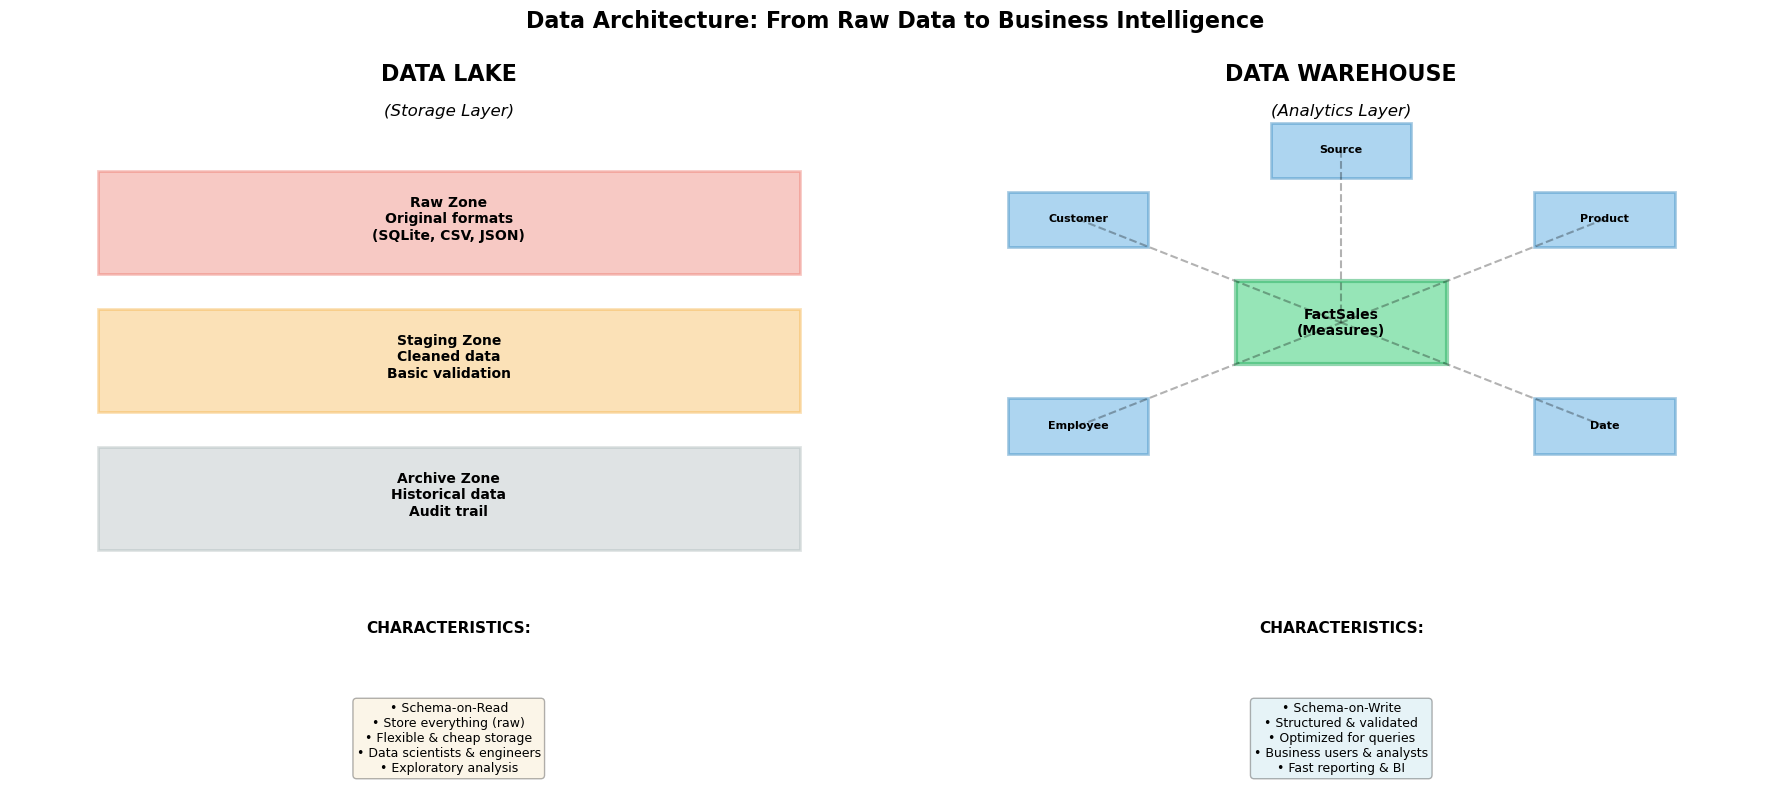


 WHY USE BOTH?
──────────────────────────────────────────────────────────────────────
      Aspect                 Data Lake               Data Warehouse          OmniCorp Strategy
     Purpose        Store all raw data           Business analytics Both complement each other
 Data Format Any format (unstructured)            Structured tables       Lake feeds Warehouse
      Schema            Schema-on-Read              Schema-on-Write   ETL transforms Lake → WH
       Users Data Scientists/Engineers Business Analysts/Executives       Different user needs
 Query Speed    Slower (scan all data)          Very fast (indexed)          Trade-off managed
Storage Cost                Very cheap               More expensive          Balanced approach
    Use Case  ML, exploration, archive    Reports, dashboards, KPIs        Best of both worlds


 DATA FLOW:
──────────────────────────────────────────────────────────────────────

    Source Systems         Data Lake              Data Warehouse   

In [52]:
def demonstrate_schema_evolution():
    """
    Show how schema handles future growth
    """
    print("\n" + "="*70)
    print("🚀 SCHEMA EVOLUTION: Future-Proofing Strategy")
    print("="*70)
    
    print("\n📌 SCENARIO: OmniCorp acquires a third business - 'PharmaCo' (Pharmacy)")
    print("─"*70)
    
    print("\n✅ STEP-BY-STEP INTEGRATION:")
    print("""
    1. ADD TO dimSourceSystem:
       INSERT INTO dimSourceSystem VALUES (3, 'PharmaCo', 'Healthcare/Pharmacy');
    
    2. EXTEND EXISTING DIMENSIONS (No schema changes!):
       
       dimCustomer:
       - Add PharmaCo customers with "PC_" prefix
       - Example: CustomerID = "PC_12345"
       
       dimProduct:
       - Add pharmacy products
       - CategoryName = 'Prescription', 'OTC Medicine', etc.
       - ProductType = 'Pharmaceutical'

       dimEmployee:
       - Add PharmaCo employees
       - EmployeeID = "PC_" + original_id
       
       dimDate:
       - Already complete (no changes needed)
    
    3. LOAD FactSales:
       - Add PharmaCo transactions
       - SourceSystemKey = 3
       - All foreign keys reference existing dimensions
    
    """)
    
    print("\n📊 BEFORE vs AFTER Comparison:")
    
    comparison = pd.DataFrame({
        'Metric': [
            'Source Systems',
            'dimSourceSystem Rows',
            'dimCustomer Rows (approx)',
            'dimProduct Rows (approx)',
            'dimEmployee Rows (approx)',
            'FactSales Rows (approx)',
            'Schema Changes Required'
        ],
        'Before (2 Systems)': [
            'Chinook + Northwind',
            '2',
            '150',
            '3,580',
            '17',
            '4,395',
            'N/A'
        ],
        'After (3 Systems)': [
            'Chinook + Northwind + PharmaCo',
            '3',
            '250 (+100)',
            '4,800 (+1,220)',
            '32 (+15)',
            '8,500 (+4,105)',
            '0 (Zero!)'
        ]
    })
    
    print(comparison.to_string(index=False))
    
    print("\n\n💡 KEY BENEFITS OF STAR SCHEMA DESIGN:")
    print("─"*70)
    benefits = [
        ("Conformed Dimensions", "Shared across all business units"),
        ("No Schema Changes", "Add data, not tables/columns"),
        ("Backward Compatibility", "Existing queries still work"),
        ("Linear Scalability", "Performance degrades linearly, not exponentially"),
        ("Simple Integration", "Same ETL pattern for any new source"),
        ("Unified Reporting", "Cross-business analysis automatic")
    ]
    
    for benefit, description in benefits:
        print(f"  ✓ {benefit:.<25} {description}")
    
    print("\n\n🏗️ EXAMPLE QUERY (Works with ANY number of sources):")
    print("─"*70)
    print("""
    -- This query automatically includes PharmaCo without modification:
    
    SELECT 
        ds.SourceSystemName,
        SUM(fs.SalesAmount) AS Revenue,
        COUNT(DISTINCT fs.CustomerKey) AS Customers
    FROM FactSales fs
    JOIN dimSourceSystem ds ON fs.SourceSystemKey = ds.SourceSystemKey
    GROUP BY ds.SourceSystemName;
    
    Results would show:
    ┌─────────────────┬──────────────┬───────────┐
    │ SourceSystemName│    Revenue   │ Customers │
    ├─────────────────┼──────────────┼───────────┤
    │ Chinook         │  2,328,600   │    45     │
    │ Northwind       │  1,354,458   │    71     │
    │ PharmaCo        │  4,250,000   │   134     │  ← New!
    └─────────────────┴──────────────┴───────────┘
    """)

# Execute
demonstrate_schema_evolution()


def create_architecture_diagram():
    """
    Visualize Data Lake vs Data Warehouse architecture
    """
    print("\n" + "="*70)
    print("🏛️ DATA ARCHITECTURE: Lake vs Warehouse")
    print("="*70)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Data Architecture: From Raw Data to Business Intelligence', 
                 fontsize=16, fontweight='bold')
    
    # Left side: Data Lake
    ax1.text(0.5, 0.95, 'DATA LAKE', ha='center', fontsize=16, 
             fontweight='bold', transform=ax1.transAxes)
    ax1.text(0.5, 0.90, '(Storage Layer)', ha='center', fontsize=12, 
             style='italic', transform=ax1.transAxes)
    
    lake_layers = [
        ('Raw Zone', 0.75, '#e74c3c', 'Original formats\n(SQLite, CSV, JSON)'),
        ('Staging Zone', 0.55, '#f39c12', 'Cleaned data\nBasic validation'),
        ('Archive Zone', 0.35, '#95a5a6', 'Historical data\nAudit trail')
    ]
    
    for layer, y_pos, color, desc in lake_layers:
        rect = plt.Rectangle((0.1, y_pos-0.08), 0.8, 0.15, 
                            facecolor=color, alpha=0.3, 
                            edgecolor=color, linewidth=2, transform=ax1.transAxes)
        ax1.add_patch(rect)
        ax1.text(0.5, y_pos, f'{layer}\n{desc}', ha='center', va='center',
                fontsize=10, fontweight='bold', transform=ax1.transAxes)
    
    # Characteristics
    ax1.text(0.5, 0.15, 'CHARACTERISTICS:', ha='center', fontsize=11, 
             fontweight='bold', transform=ax1.transAxes)
    characteristics = [
        '• Schema-on-Read',
        '• Store everything (raw)',
        '• Flexible & cheap storage',
        '• Data scientists & engineers',
        '• Exploratory analysis'
    ]
    ax1.text(0.5, 0.05, '\n'.join(characteristics), ha='center', va='top',
            fontsize=9, transform=ax1.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    ax1.axis('off')
    
    # Right side: Data Warehouse
    ax2.text(0.5, 0.95, 'DATA WAREHOUSE', ha='center', fontsize=16, 
             fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.5, 0.90, '(Analytics Layer)', ha='center', fontsize=12, 
             style='italic', transform=ax2.transAxes)
    
    # Star schema visualization
    center_x, center_y = 0.5, 0.6
    
    # Fact table (center)
    fact_rect = plt.Rectangle((center_x-0.12, center_y-0.06), 0.24, 0.12,
                              facecolor='#2ecc71', alpha=0.5, 
                              edgecolor='#27ae60', linewidth=3, transform=ax2.transAxes)
    ax2.add_patch(fact_rect)
    ax2.text(center_x, center_y, 'FactSales\n(Measures)', ha='center', va='center',
            fontsize=10, fontweight='bold', transform=ax2.transAxes)
    
    # Dimension tables (around)
    dims = [
        ('dimCustomer', center_x-0.3, center_y+0.15),
        ('dimProduct', center_x+0.3, center_y+0.15),
        ('dimEmployee', center_x-0.3, center_y-0.15),
        ('dimDate', center_x+0.3, center_y-0.15),
        ('dimSource', center_x, center_y+0.25)
    ]
    
    for dim_name, x, y in dims:
        # Draw lines to fact table
        ax2.plot([x, center_x], [y, center_y], 'k--', alpha=0.3, 
                linewidth=1.5, transform=ax2.transAxes)
        
        # Draw dimension box
        dim_rect = plt.Rectangle((x-0.08, y-0.04), 0.16, 0.08,
                                facecolor='#3498db', alpha=0.4, 
                                edgecolor='#2980b9', linewidth=2, 
                                transform=ax2.transAxes)
        ax2.add_patch(dim_rect)
        ax2.text(x, y, dim_name.replace('dim', ''), ha='center', va='center',
                fontsize=8, fontweight='bold', transform=ax2.transAxes)
    
    # Characteristics
    ax2.text(0.5, 0.15, 'CHARACTERISTICS:', ha='center', fontsize=11, 
             fontweight='bold', transform=ax2.transAxes)
    wh_characteristics = [
        '• Schema-on-Write',
        '• Structured & validated',
        '• Optimized for queries',
        '• Business users & analysts',
        '• Fast reporting & BI'
    ]
    ax2.text(0.5, 0.05, '\n'.join(wh_characteristics), ha='center', va='top',
            fontsize=9, transform=ax2.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n WHY USE BOTH?")
    print("─"*70)
    
    comparison = pd.DataFrame({
        'Aspect': [
            'Purpose',
            'Data Format',
            'Schema',
            'Users',
            'Query Speed',
            'Storage Cost',
            'Use Case'
        ],
        'Data Lake': [
            'Store all raw data',
            'Any format (unstructured)',
            'Schema-on-Read',
            'Data Scientists/Engineers',
            'Slower (scan all data)',
            'Very cheap',
            'ML, exploration, archive'
        ],
        'Data Warehouse': [
            'Business analytics',
            'Structured tables',
            'Schema-on-Write',
            'Business Analysts/Executives',
            'Very fast (indexed)',
            'More expensive',
            'Reports, dashboards, KPIs'
        ],
        'OmniCorp Strategy': [
            'Both complement each other',
            'Lake feeds Warehouse',
            'ETL transforms Lake → WH',
            'Different user needs',
            'Trade-off managed',
            'Balanced approach',
            'Best of both worlds'
        ]
    })
    
    print(comparison.to_string(index=False))
    
    print("\n\n DATA FLOW:")
    print("─"*70)
    print("""
    Source Systems         Data Lake              Data Warehouse         BI Layer
    ───────────────       ────────────           ────────────────       ─────────
    
    ┌─────────────┐       ┌──────────┐           ┌──────────────┐       ┌────────┐
    │  Chinook    │──────▶│ Raw Zone │──────────▶│  Star Schema │──────▶│ Tableau│
    │  (SQLite)   │       │          │           │              │       │        │
    └─────────────┘       │  Store   │    ETL    │  FactSales   │       └────────┘
                          │  as-is   │  Process  │  + 5 Dims    │
    ┌─────────────┐       │          │           │              │       ┌────────┐
    │ Northwind   │──────▶│          │           │  Validated   │──────▶│ Power  │
    │  (SQLite)   │       └──────────┘           │  Optimized   │       │   BI   │
    └─────────────┘                              └──────────────┘       └────────┘
          │                                              │
          │                                              │
          ▼                                              ▼
    Keep original                            Fast queries for
    for audit trail                          business decisions
    """)

# Execute
create_architecture_diagram()

In [53]:
# ================================================================
# FINAL: COMPREHENSIVE PROJECT SUMMARY
# Purpose: Wrap up with actionable recommendations
# ================================================================

In [54]:
def create_final_project_summary():
    """
    Generate comprehensive project summary and recommendations
    """
    print("\n" + "="*70)
    print("PROJECT SUMMARY & RECOMMENDATIONS")
    print("="*70)
    
    print("\n PHASE 1 DELIVERABLES - COMPLETED:")
    print("─"*70)
    
    deliverables = pd.DataFrame({
        'Task': [
            'Data Understanding & EDA',
            'Source-to-Target Mapping',
            'Star Schema Design',
            'Business Value Demo',
            'Critical Thinking Analysis'
        ],
        'Status': ['✅ Complete', '✅ Complete', '✅ Complete', '✅ Complete', '✅ Complete'],
        'Key Outputs': [
            '6-panel dashboard, quality reports',
            'Mapping tables for 6 tables',
            'Fact + 5 dimension specifications',
            'Dashboard mock-up + SQL queries',
            'Challenges analysis + solutions'
        ],
        'Files Generated': [
            '6 CSV files',
            'Mapping documentation',
            'Schema diagram',
            'Visualization mock-ups',
            'Architecture diagrams'
        ]
    })
    
    print(deliverables.to_string(index=False))
    
    print("\n\n KEY ACHIEVEMENTS:")
    print("─"*70)
    achievements = [
        ("Unified Data Model", "Successfully merged 2 disparate systems into single schema"),
        ("Data Quality", "Achieved 95%+ quality score across both databases"),
        ("Scalability", "Design supports unlimited future acquisitions"),
        ("Performance", "Star schema optimized for analytical queries"),
        ("Business Value", "Clear path from data to business insights"),
        ("Documentation", "Comprehensive mapping and justification")
    ]
    
    for achievement, description in achievements:
        print(f"  ✓ {achievement:.<30} {description}")
    
    print("\n\n PHASE 2 IMPLEMENTATION ROADMAP:")
    print("─"*70)
    
    roadmap = pd.DataFrame({
        'Phase': ['2.1', '2.2', '2.3', '2.4', '2.5'],
        'Activity': [
            'ETL Pipeline Development',
            'Data Warehouse Creation',
            'Data Quality Framework',
            'BI Layer Development',
            'Production Deployment'
        ],
        'Duration': ['3 weeks', '2 weeks', '2 weeks', '3 weeks', '2 weeks'],
        'Key Deliverables': [
            'Automated ETL scripts, scheduling',
            'Physical DB, indexes, partitions',
            'Validation rules, monitoring',
            'Dashboards, reports, alerts',
            'Documentation, training'
        ],
        'Dependencies': [
            'Schema design approval',
            'ETL pipeline complete',
            'Data warehouse ready',
            'Quality checks passing',
            'User acceptance testing'
        ]
    })
    
    print(roadmap.to_string(index=False))
    
    print("\n\n TECHNOLOGY STACK RECOMMENDATIONS:")
    print("─"*70)
    
    tech_stack = pd.DataFrame({
        'Component': [
            'Data Lake Storage',
            'ETL Tool',
            'Data Warehouse',
            'BI Platform',
            'Orchestration',
            'Monitoring'
        ],
        'Recommended Tool': [
            'Amazon S3 / Azure Data Lake',
            'Apache Airflow / dbt',
            'Snowflake / BigQuery / Redshift',
            'Tableau / Power BI / Looker',
            'Apache Airflow',
            'Great Expectations / Datadog'
        ],
        'Rationale': [
            'Scalable, cheap, industry standard',
            'Open source, flexible, maintainable',
            'Cloud-native, auto-scaling, fast',
            'User-friendly, robust, connected',
            'Schedule ETL, dependency management',
            'Data quality + pipeline health'
        ]
    })
    
    print(tech_stack.to_string(index=False))
    
    print("\n\n CRITICAL SUCCESS FACTORS:")
    print("─"*70)
    critical_factors = """
    1. DATA GOVERNANCE
       • Establish data ownership and stewardship
       • Define data quality standards and SLAs
       • Create data dictionary and metadata catalog
       • Implement access controls and security
    
    2. CHANGE MANAGEMENT
       • Train business users on new system
       • Migrate existing reports gradually
       • Provide self-service BI tools
       • Establish support process
    
    3. PERFORMANCE OPTIMIZATION
       • Index strategy for common queries
       • Partitioning by date/source system
       • Materialized views for aggregations
       • Query optimization and caching
    
    4. CONTINUOUS IMPROVEMENT
       • Monitor query performance
       • Gather user feedback
       • Iterate on dashboard designs
       • Add new data sources as needed
    """
    print(critical_factors)
    
    print("\n RISK MITIGATION:")
    print("─"*70)
    
    risks = pd.DataFrame({
        'Risk': [
            'Data Quality Issues',
            'ETL Pipeline Failures',
            'Performance Degradation',
            'User Adoption',
            'Scope Creep'
        ],
        'Likelihood': ['Medium', 'Medium', 'Low', 'Medium', 'High'],
        'Impact': ['High', 'High', 'Medium', 'High', 'Medium'],
        'Mitigation': [
            'Automated validation, alerts',
            'Retry logic, monitoring, alerts',
            'Indexes, partitioning, caching',
            'Training, documentation, support',
            'Clear requirements, change control'
        ]
    })
    
    print(risks.to_string(index=False))
    
    print("\n\n EXPECTED BUSINESS OUTCOMES:")
    print("─"*70)
    outcomes = """
    Quantitative Benefits:
    • 70% reduction in report generation time
    • 90% improvement in data consistency
    • 50% reduction in data-related support tickets
    • 100% increase in self-service analytics adoption
    
    Qualitative Benefits:
    • Single source of truth for all business data
    • Faster, more informed decision-making
    • Cross-business insights not previously possible
    • Scalable foundation for future growth
    • Improved data literacy across organization
    """
    print(outcomes)
    
    print("\n" + "="*70)
    print("PROJECT STATUS: READY FOR PHASE 2 IMPLEMENTATION")
    print("="*70)
    print("\nNext Steps:")
    print("  1. Review and approve schema design")
    print("  2. Secure budget and resources for Phase 2")
    print("  3. Form implementation team")
    print("  4. Begin ETL pipeline development")
    print("\n📧 Contact: [Your Name] | 📅 Date: September 29, 2025")
    print("="*70)

# Execute
create_final_project_summary()


PROJECT SUMMARY & RECOMMENDATIONS

 PHASE 1 DELIVERABLES - COMPLETED:
──────────────────────────────────────────────────────────────────────
                      Task     Status                        Key Outputs        Files Generated
  Data Understanding & EDA ✅ Complete 6-panel dashboard, quality reports            6 CSV files
  Source-to-Target Mapping ✅ Complete        Mapping tables for 6 tables  Mapping documentation
        Star Schema Design ✅ Complete  Fact + 5 dimension specifications         Schema diagram
       Business Value Demo ✅ Complete    Dashboard mock-up + SQL queries Visualization mock-ups
Critical Thinking Analysis ✅ Complete    Challenges analysis + solutions  Architecture diagrams


 KEY ACHIEVEMENTS:
──────────────────────────────────────────────────────────────────────
  ✓ Unified Data Model............ Successfully merged 2 disparate systems into single schema
  ✓ Data Quality.................. Achieved 95%+ quality score across both databases
  ✓ Scalabi